In [8]:
!pip install seaborn

In [3]:
#import seaborn as sns
import os.path
import numpy as np
%matplotlib inline
%run imports.py
%run lib_util.py
%run lib_plot.py
%run lib_summary.py
%run lib_misc.py
# Get all data
rawDataSet = loadRawData()
subsampleDataSet = loadSubsampleData()
featureDataSet = loadFeatureData()
offlineCorrDataSet = loadOfflineCorrData()
# onlineCorrDataSet = load
lagDataSet = loadLagData()
leftTicksSet, rightTicksSet = loadFlashData(rawDataSet)
import matplotlib as mpl
DPI = 200
mpl.rc("savefig", dpi=DPI)
mpl.rcParams['figure.dpi']= DPI
mpl.rcParams.update({'font.size': 14})

done loading raw data
done loading subsample data
done loading feature
done loading offline
done loading lag
done loading flashes


## Figure 5

key: t20171025002658_p3_prep_x2_raw.csv


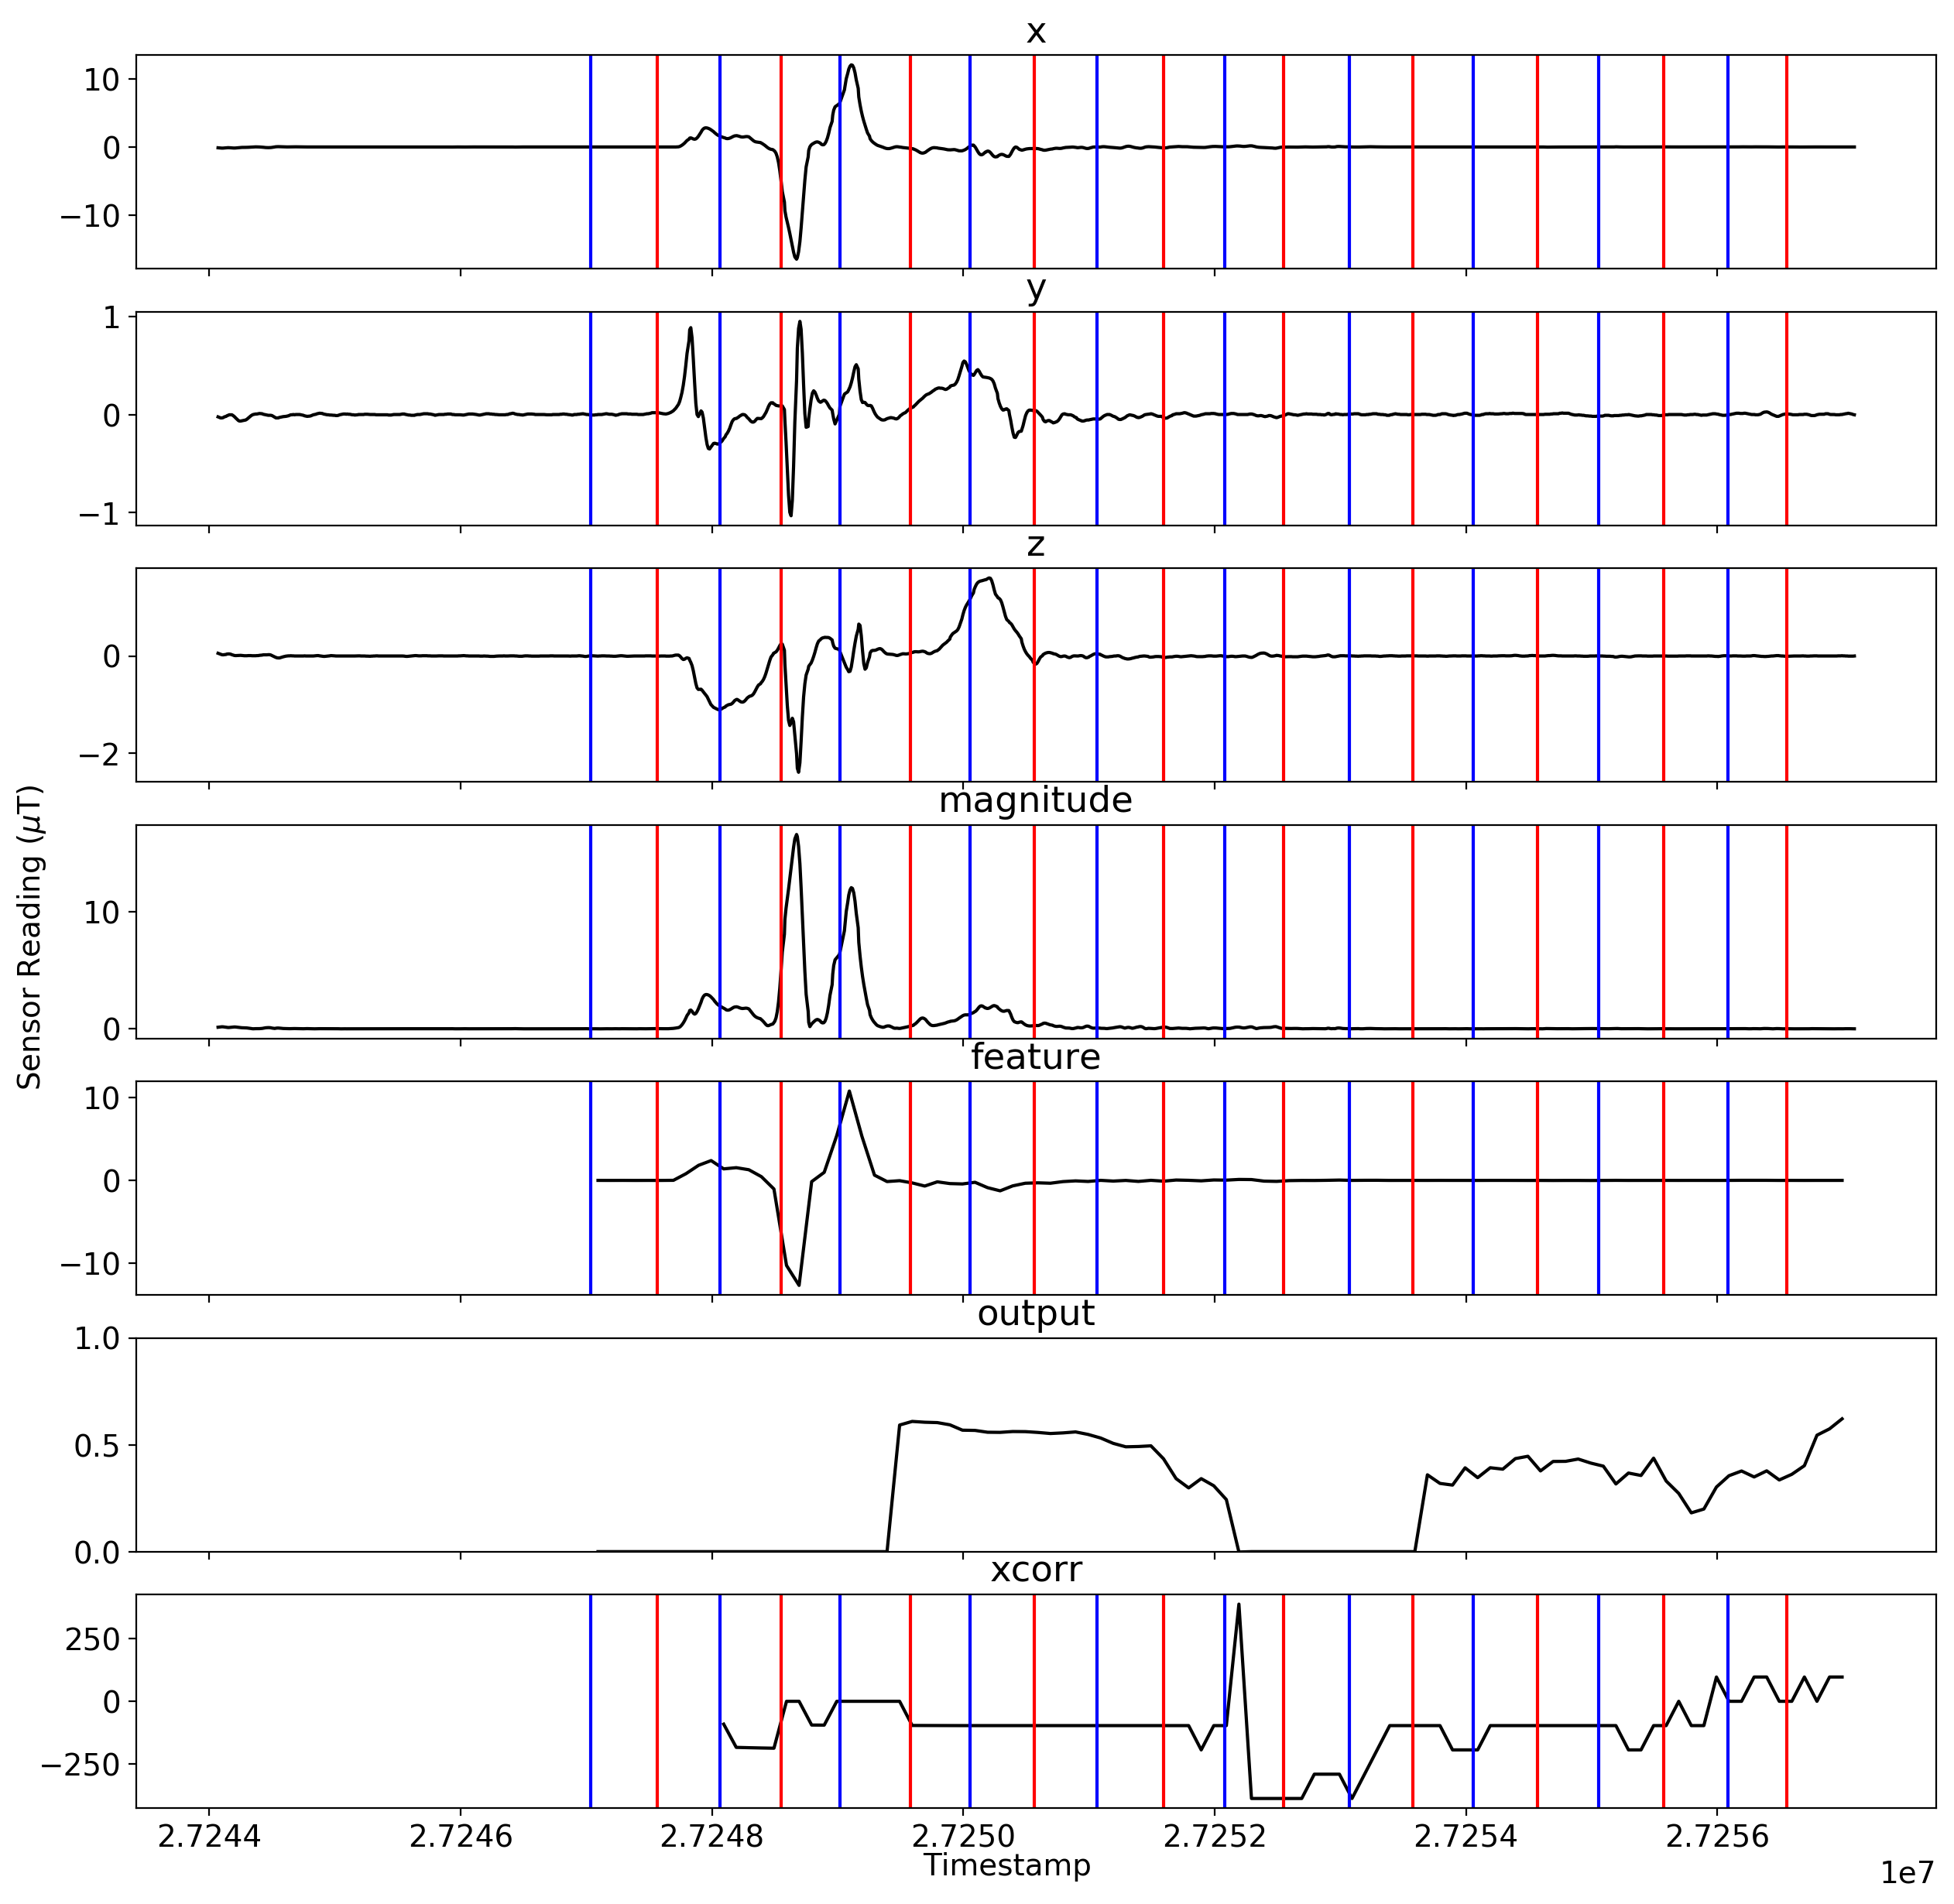

key: t20171025002658_p3_prep_x3_raw.csv


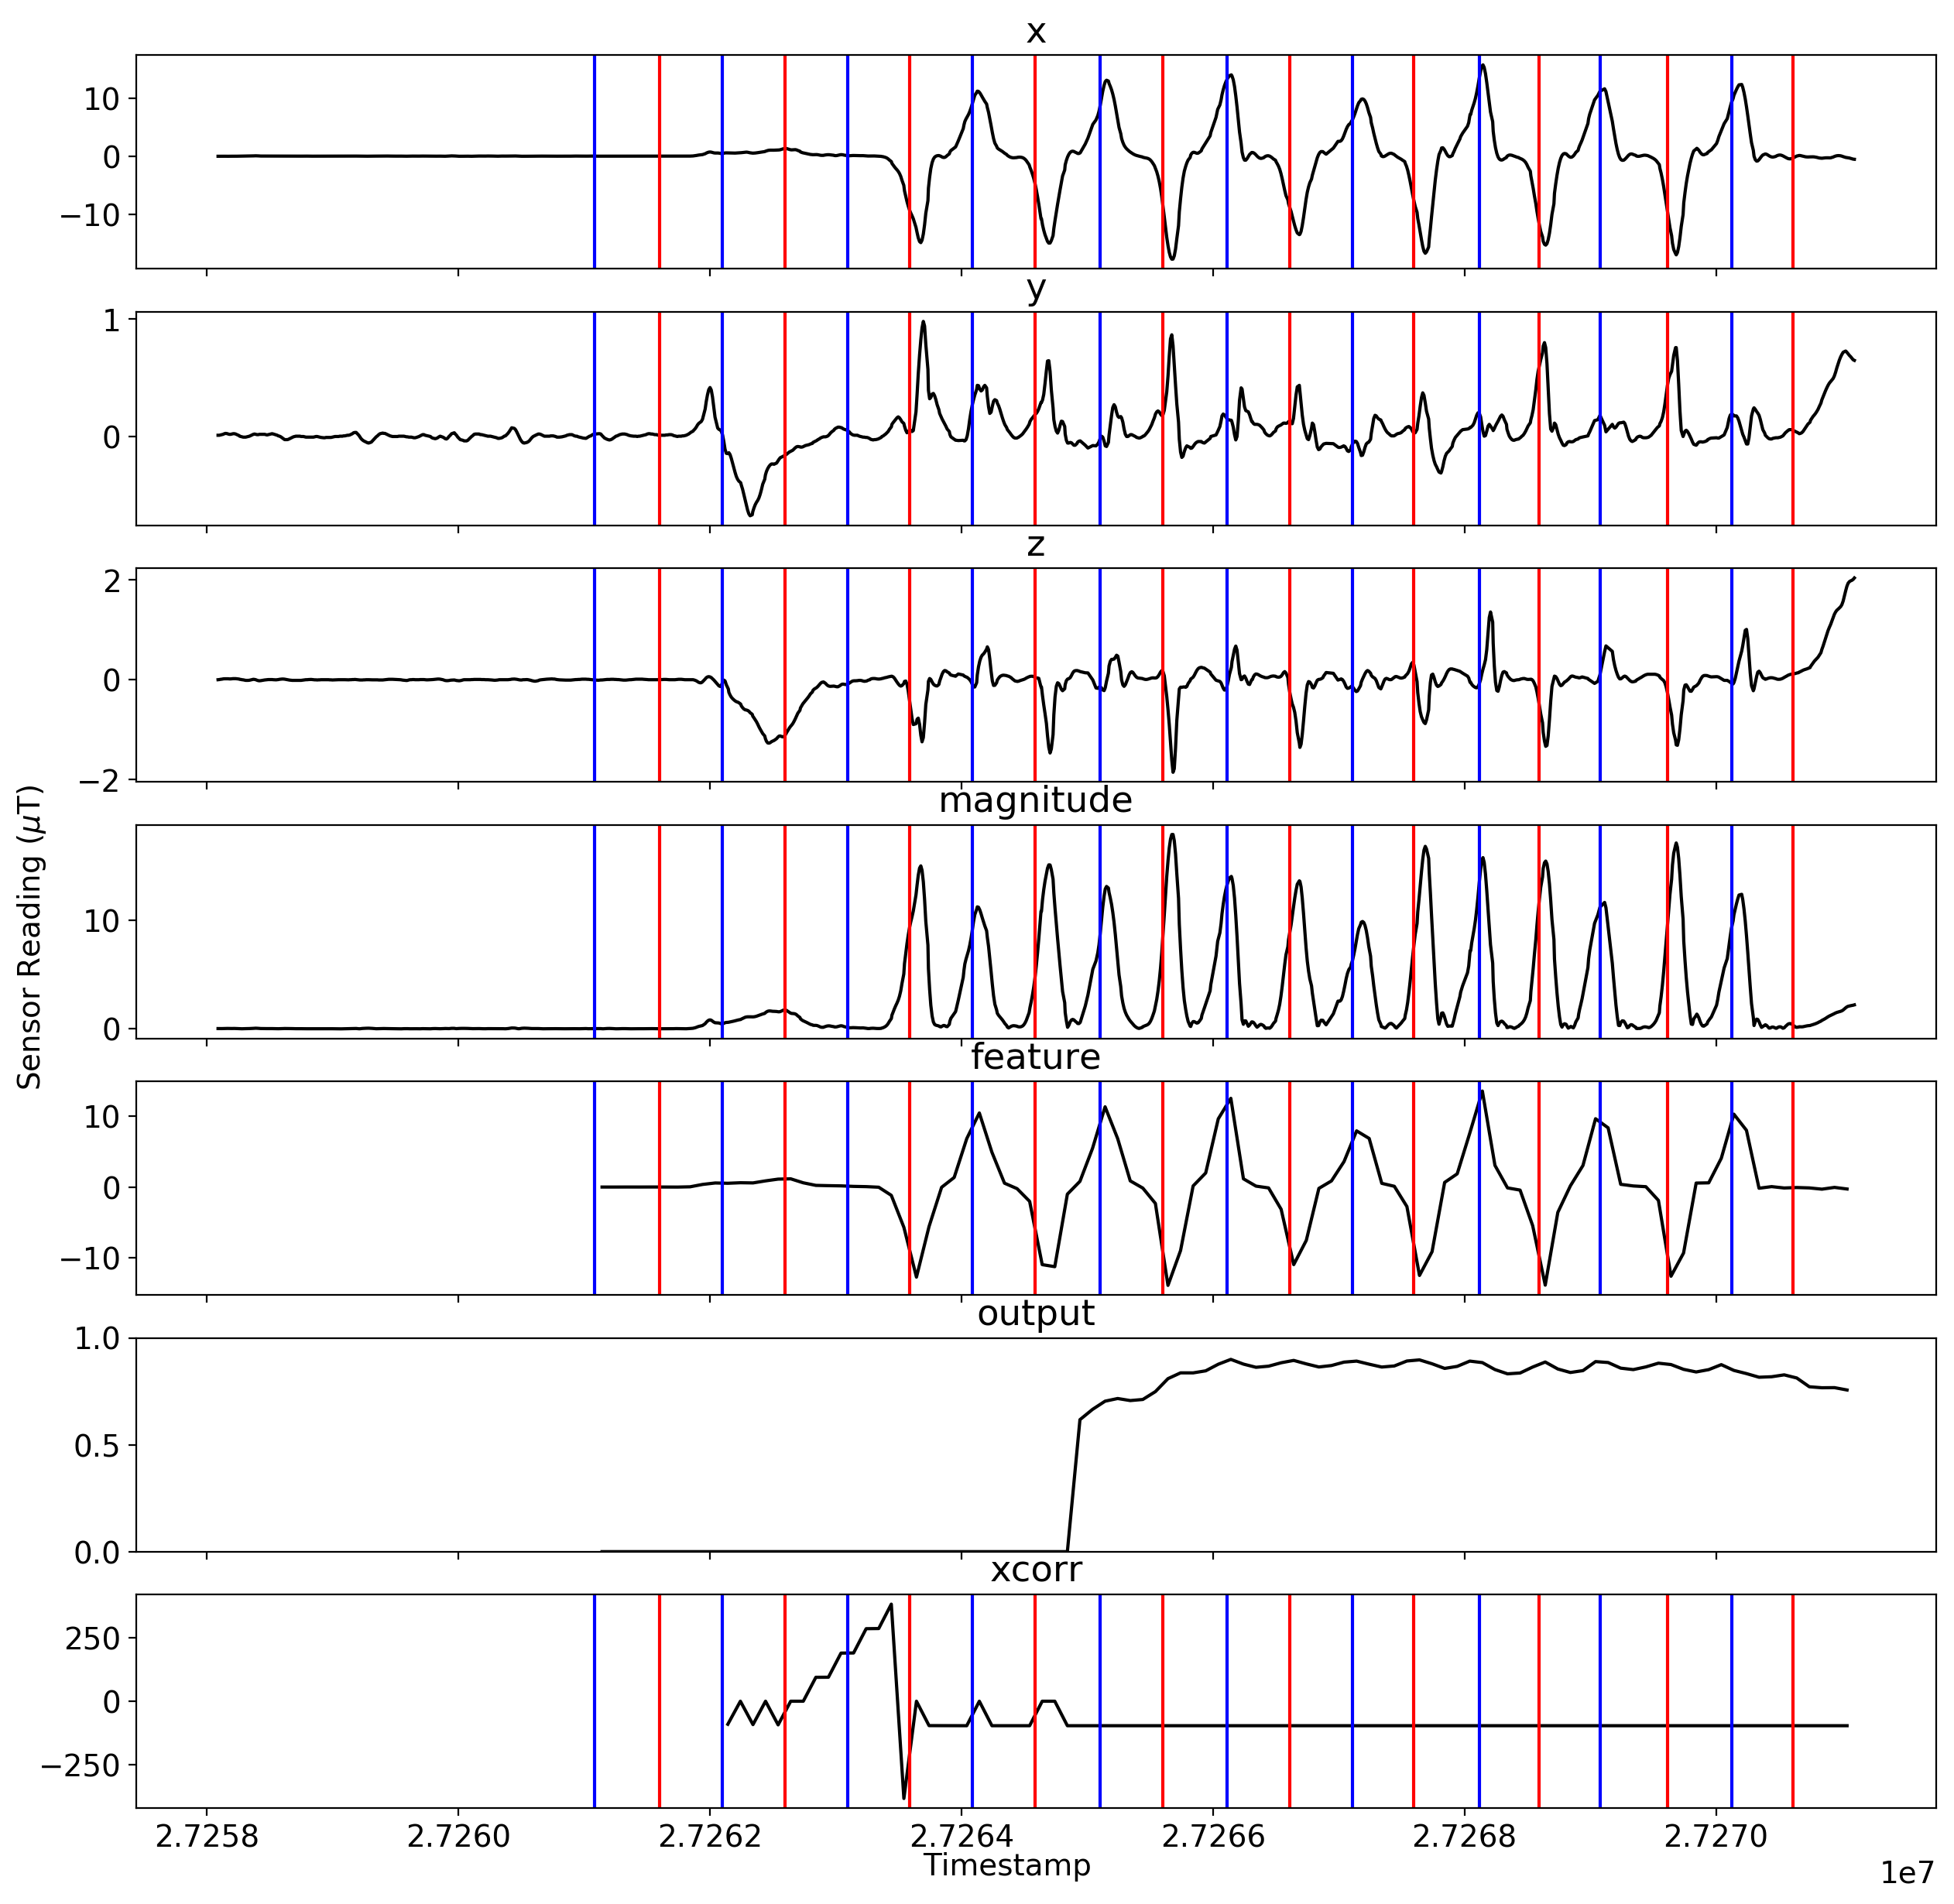

key: t20171025002658_p3_prep_x4_raw.csv


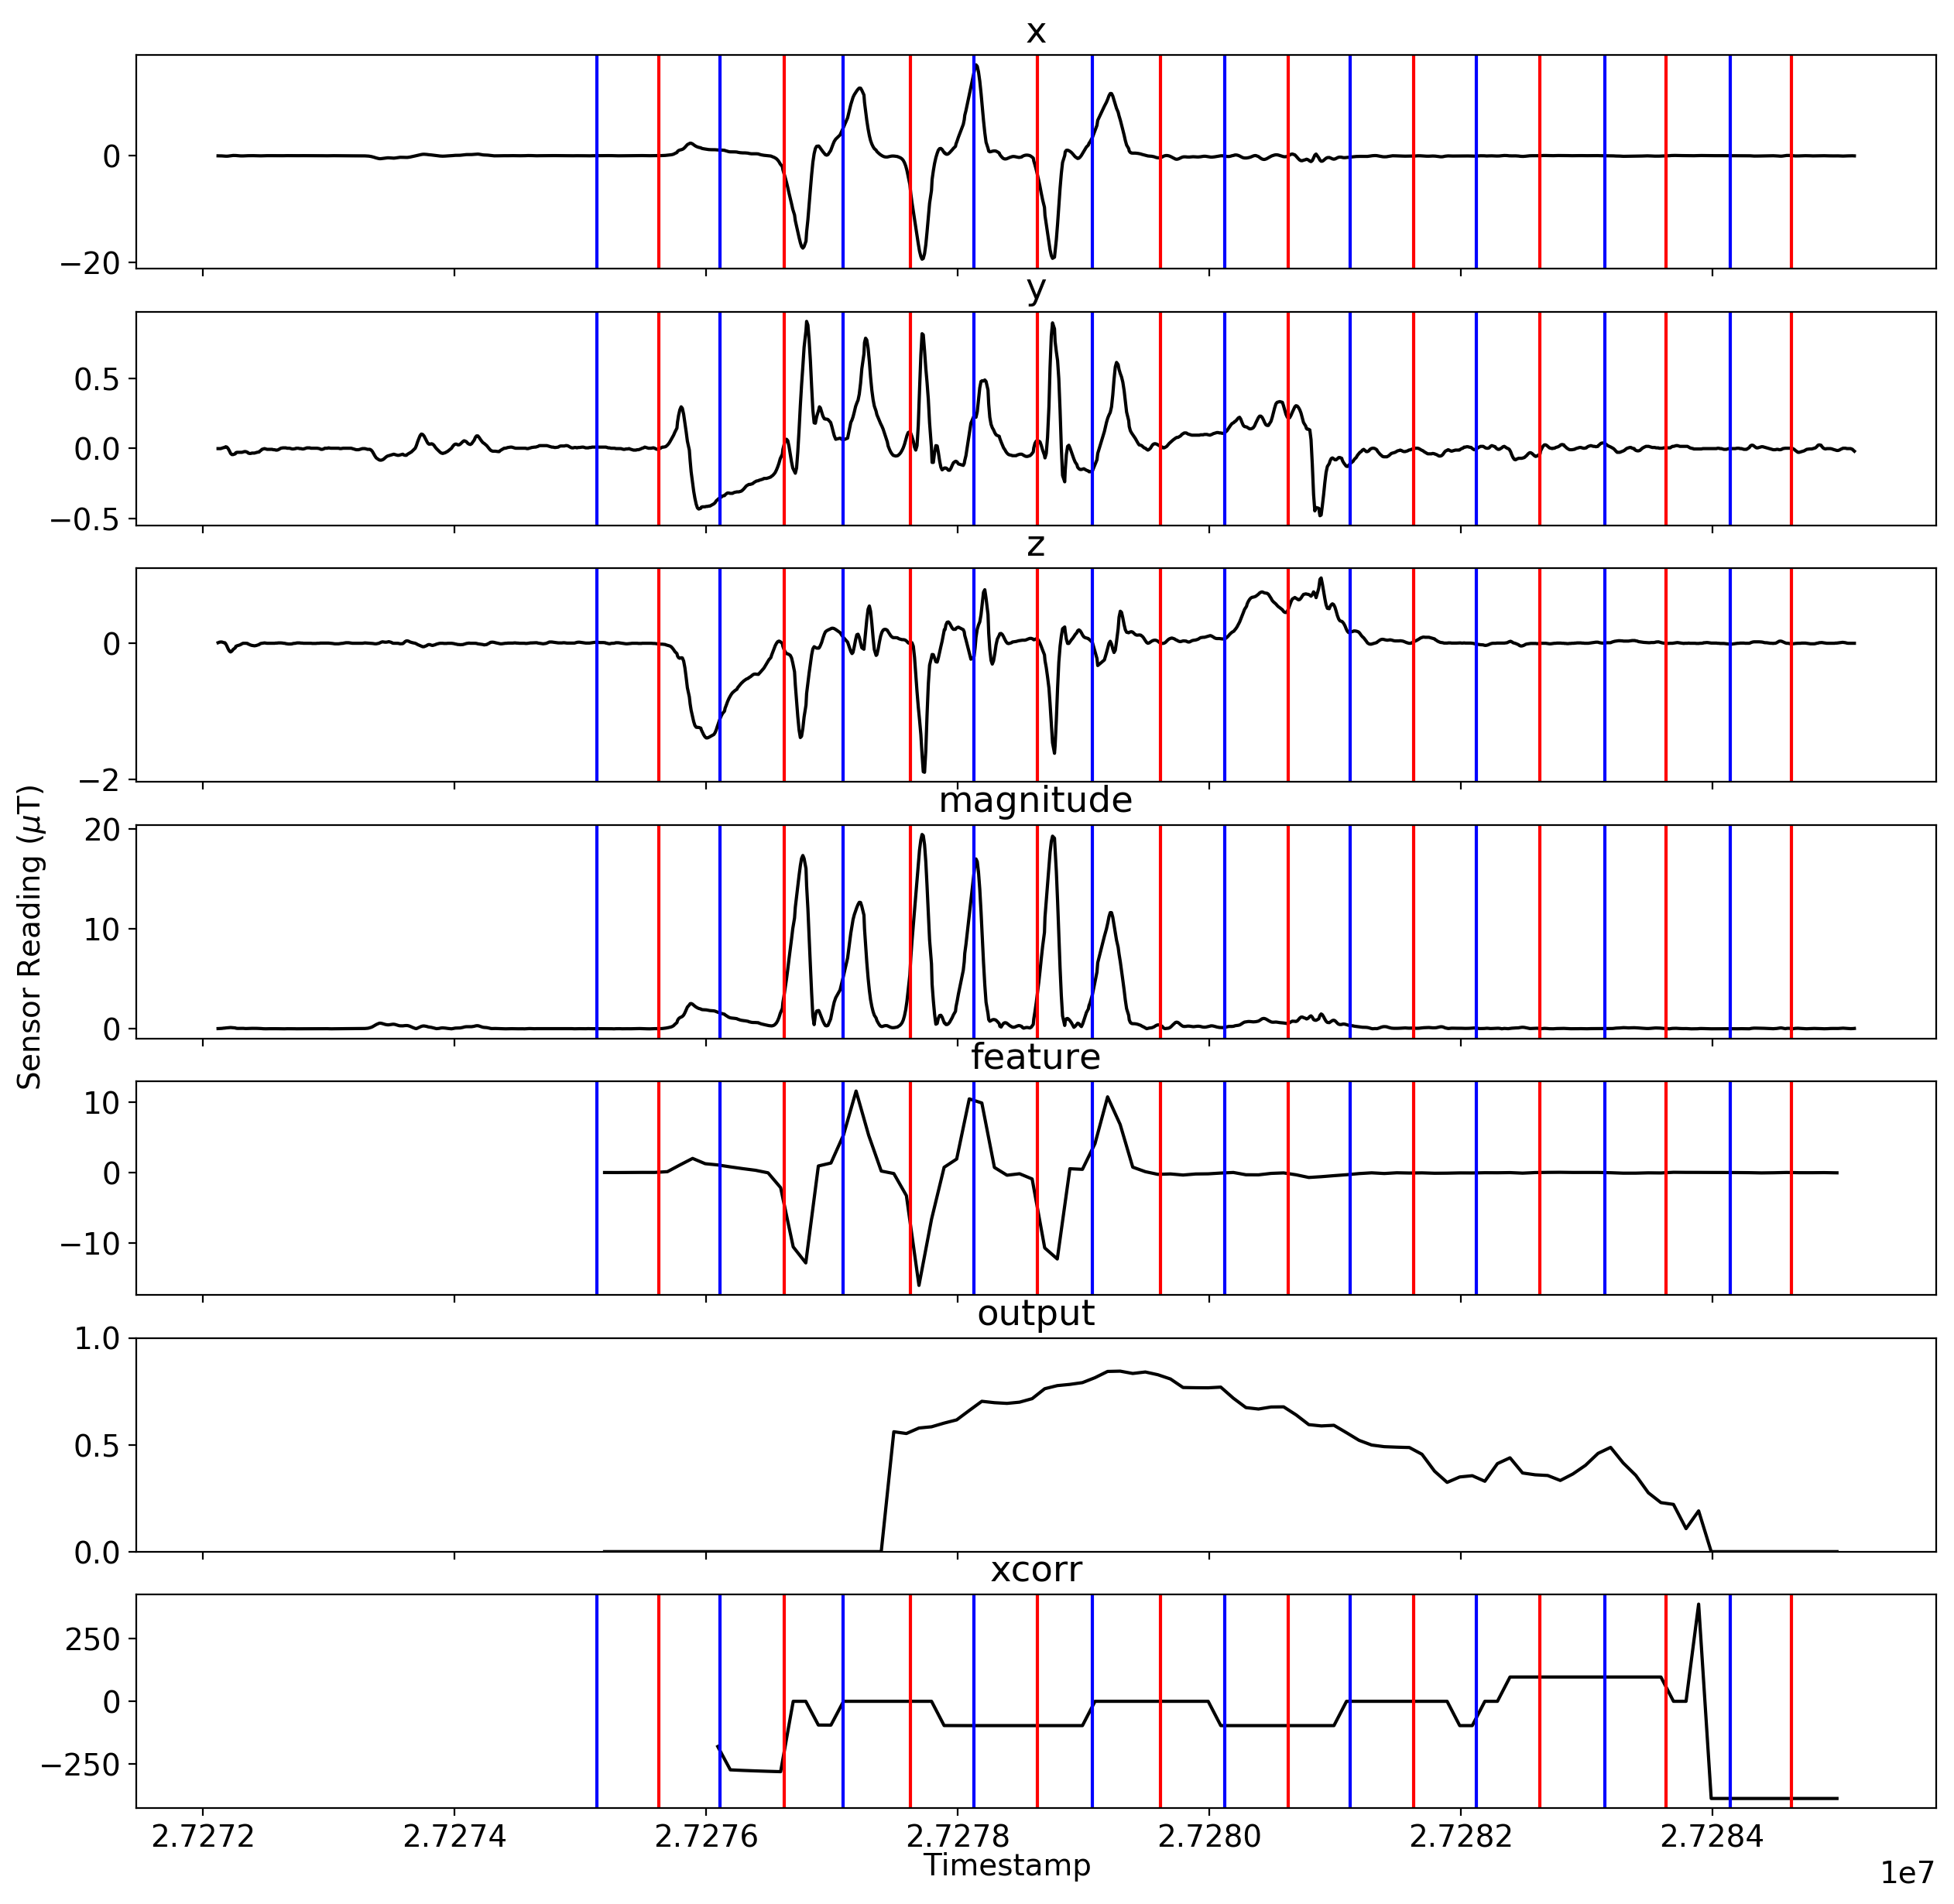

key: t20171025002658_p3_prep_x5_raw.csv


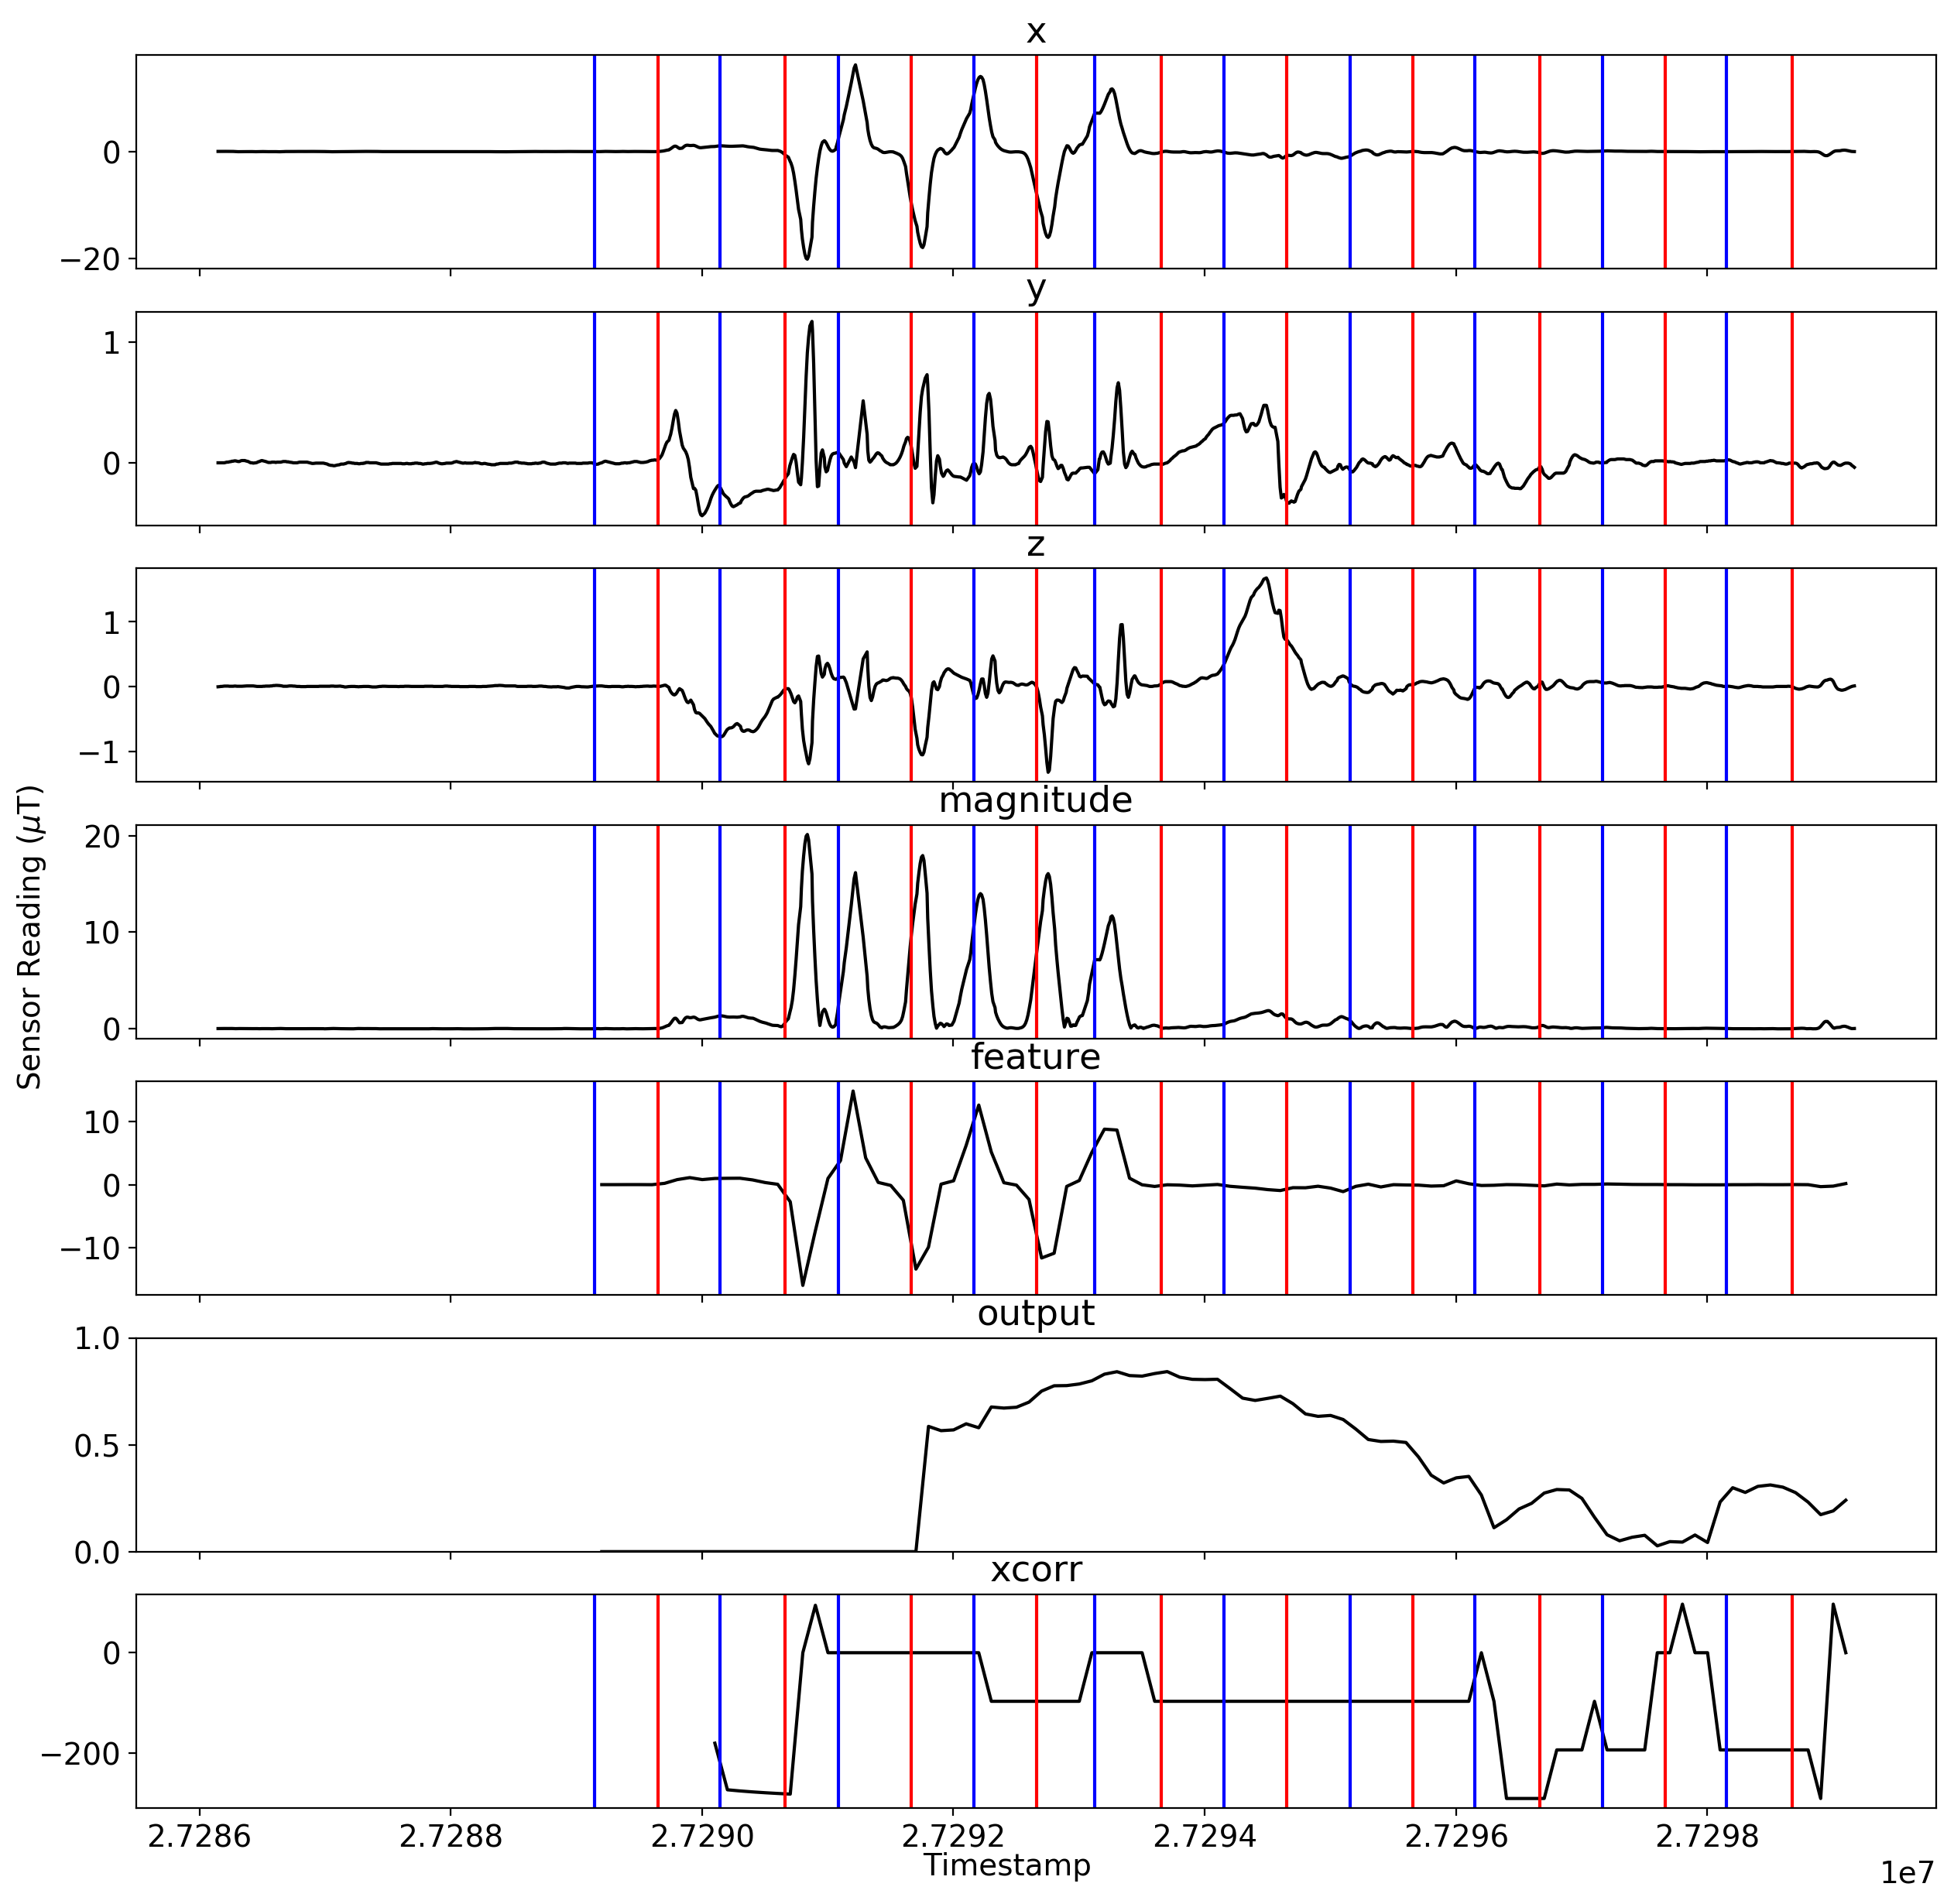

key: t20171025002658_p3_prep_x1_raw.csv


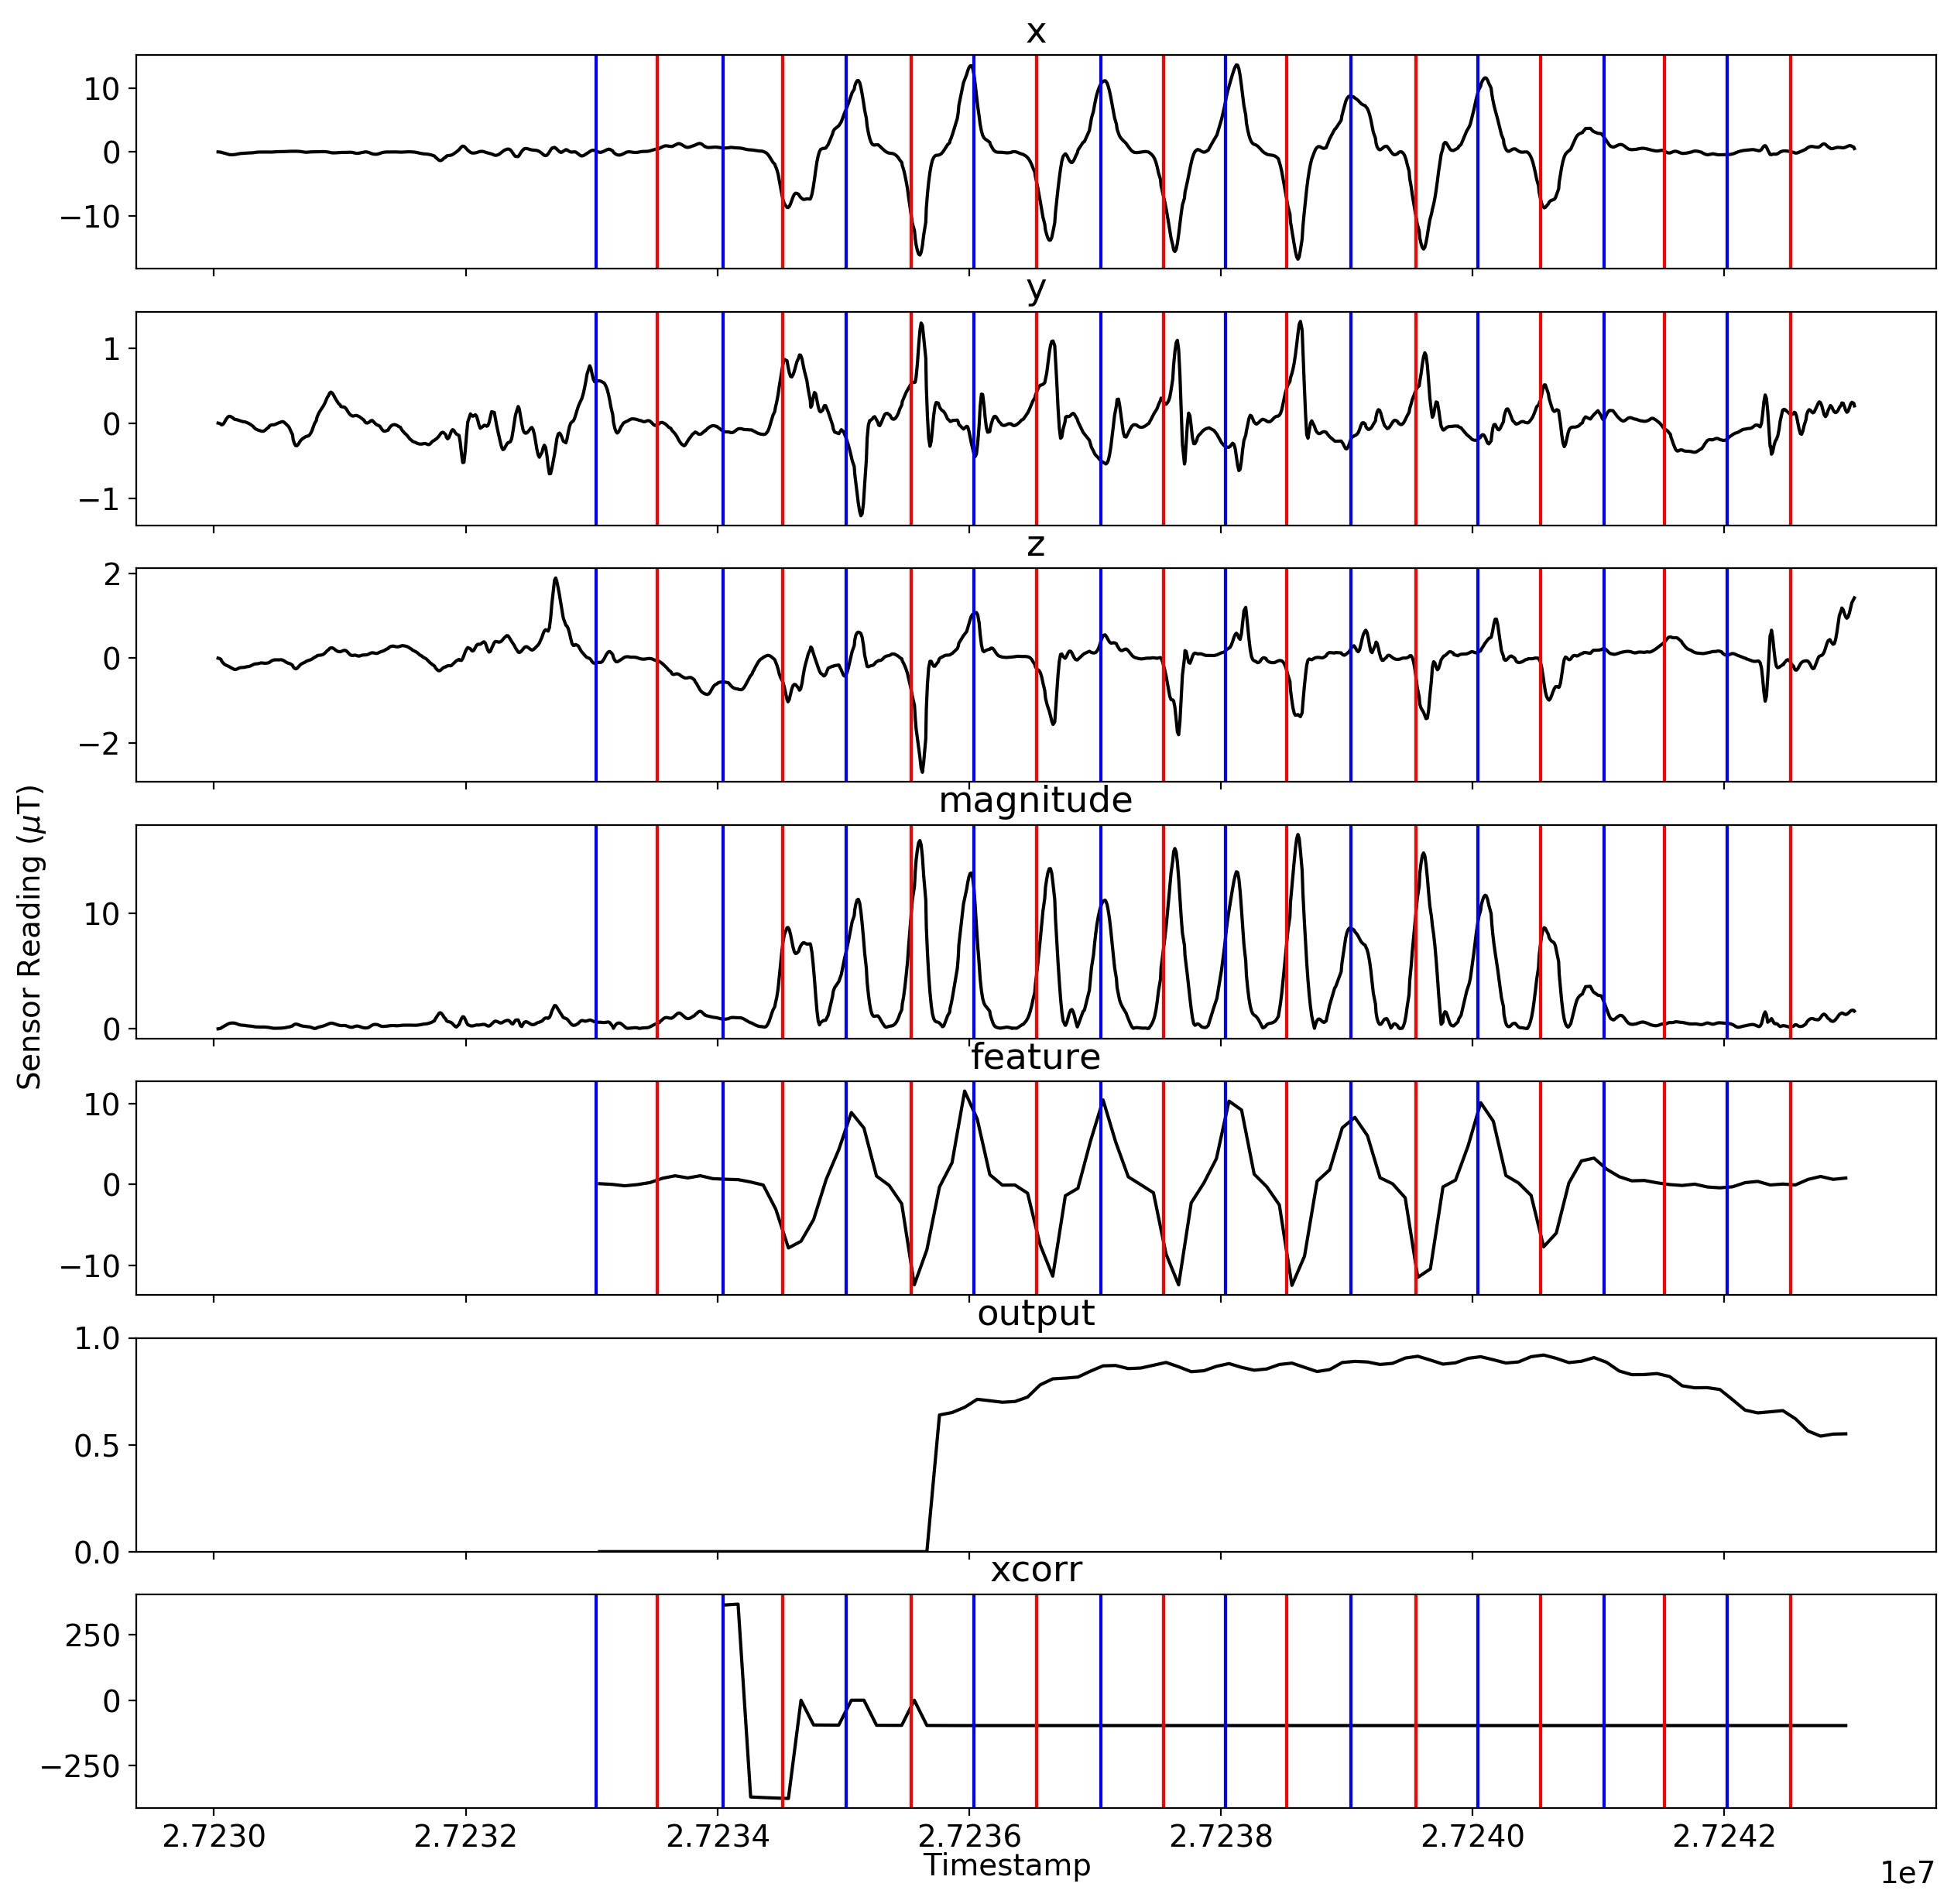

done plotting overview


In [4]:
vizOverview(rawDataSet, subsampleDataSet, featureDataSet, offlineCorrDataSet, lagDataSet, plotSubsample=False, saveToFile=False, compact=False, excerpt=False, smooth=False)

## Figure 4

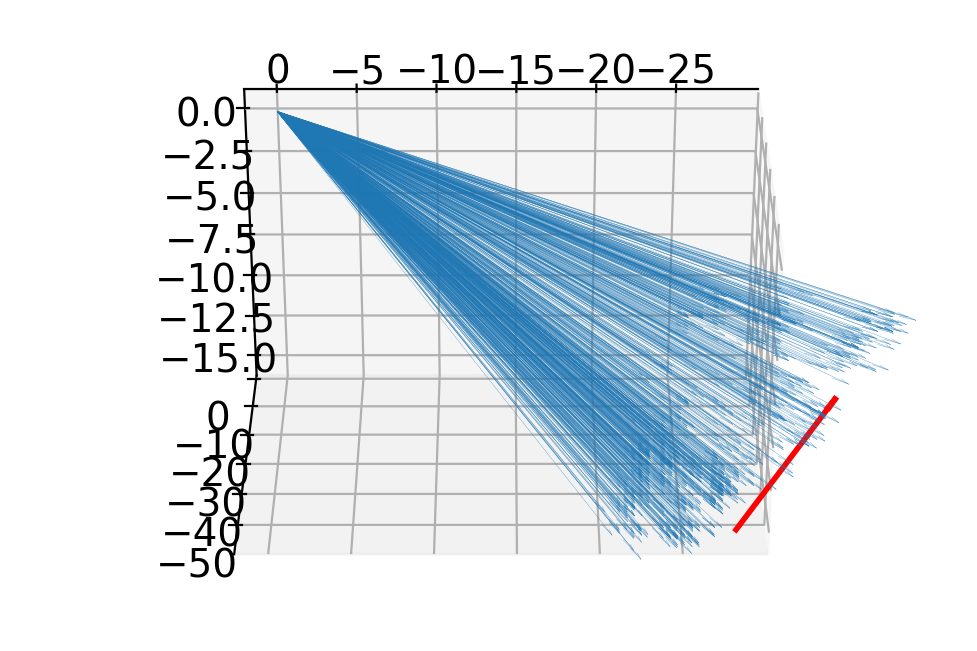

In [3]:
import pandas as pd
import matplotlib.pyplot as pplot

PLOT_SENSOR = "magnet"
def mag(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)
def magv(v):
    return np.sqrt(v.dot(v))
csvData = pd.read_csv("/media/jwpilly/PillowDisk/Research/Synchro/figuredata/figure4/p1_t1478897598685_xbrowsing1250_4_ssensorData.csv", names=['time','sensor','x','y','z','timestamp','linecounter',''])
plotX = []
plotY = []
plotZ = []
plotMag = []
plotVector = []
vectors = []
pplot.clf()
lefts = []
rights = []
llx = 0
lly = 0
llz = 0
for rowI in range(len(csvData['sensor']) // 3, len(csvData['sensor']) - len(csvData['sensor']) // 4):
    row = csvData['sensor'][rowI]
    if row == PLOT_SENSOR:
        x = csvData['x'][rowI]
        y = csvData['y'][rowI]
        z = csvData['z'][rowI]
        t = csvData['time'][rowI]
        plotX.append((t, x))
        plotY.append((t, y))
        plotZ.append((t, z))
        plotMag.append((t, mag(x, y, z)))
        plotVector.append([0, 0, 0, x, y, z])
        vectors.append([x, y, z])
        llx = x
        lly = y
        llz = z
    elif row == 'left':
        lefts.append([llx, lly, llz])
    elif row == 'right':
        rights.append([llx, lly, llz])
    elif row == 'vibrate':
        #pplot.axvline(x=csvData['time'][rowI], color='green')
        pass
lefts = np.array(lefts)
rights = np.array(rights)
# lm = lefts.mean(axis = 0)
# rm = rights.mean(axis = 0)
# dm = lm - rm
deltas = [lefts[vi] - rights[vi] for vi in range(min(len(lefts), len(rights)))]
deltas = np.array(deltas)
dm = deltas.mean(axis=0)
import matplotlib.pyplot as plt

vectors = np.array(vectors)
# from sklearn.decomposition import PCA
# pca = PCA(n_components=1)
# pca.fit(vectors)
# pa = pca.components_[0]
# pvectors = [[0,0,0,pa[0],pa[1],pa[2]]]
# pvectors = np.array(pvectors)
soa =np.array(plotVector) 
def get_mid(v):
    return np.min(v) + ((np.max(v) - np.min(v)) / 2)
    # return np.mean(np.min(v), np.max(v))

X,Y,Z,U,V,W = zip(*soa)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X,Y,Z,U,V,W, pivot="tail", arrow_length_ratio=0.02, length=magv(vectors.mean(axis=0)) / 75, linewidths=0.1)
# dv = np.array([np.array(get_mid(U)), get_mid(np.array(V)), get_mid(np.array(W))])
dv = rights.mean(axis=0)
pvectors = [[dv[0], dv[1], dv[2], dm[0], dm[1], dm[2]]]
# pvectors = [[0, 0, 0, dm[0], dm[1], dm[2]]]
pvectors = np.array(pvectors)
X2,Y2,Z2,U2,V2,W2 = zip(*pvectors)
ax.quiver(X2,Y2,Z2,U2,V2,W2, pivot="tail", arrow_length_ratio=0.1,color="red", length=magv(deltas.mean(axis=0)), linewidths=2)
ax.view_init(-60,90)
bound = 10
# ax.set_xlim([-bound,bound])
# ax.set_ylim([-bound,bound])
# ax.set_zlim([-bound,bound])
pplot.show()

## Figure 6

/home/jwpilly/anaconda3/envs/synchro/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  if sys.path[0] == '':


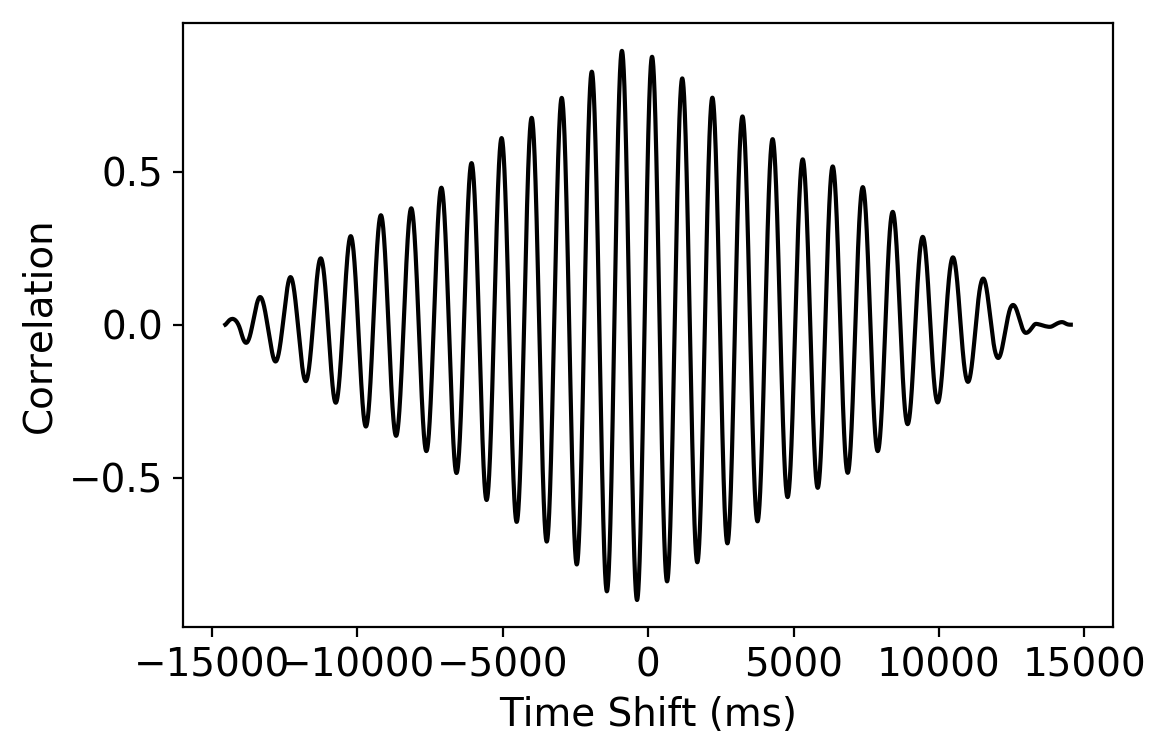

In [4]:
from scipy.signal import detrend
from scipy.signal import resample
FIT_SQUARE = False
def delta_space_transform(leftVector, rightVector, currentVector, lastLeft):
    deltaVector = leftVector - rightVector
    currentDeltaVector = currentVector - leftVector if lastLeft else currentVector - rightVector
    scalarProjection = currentDeltaVector.dot(deltaVector) / magv(deltaVector)
    return scalarProjection
def get_ewma(df, alpha=1):
    # Compute alpha and exponential moving average
    span = (2-alpha)/alpha
    df_smooth = pd.ewma(df, span=span, adjust=False)
    return df_smooth
def remove_trend(x):
    return detrend(x)
csvData = pd.read_csv("/media/jwpilly/PillowDisk/Research/Synchro/figuredata/figure6/p1_t1478897598685_xsitting1000_5_ssensorData.csv", names=['time','sensor','x','y','z','timestamp','linecounter',''])
plotX = []
plotY = []
plotZ = []
plotMag = []
plotT = []
plotTL = []
pplot.clf()
f, (ax1) = pplot.subplots(1)
lx = 0
ly = 0
lz = 0
rx = 0
ry = 0
rz = 0
lastLeft = None
leftEvents = []
rightEvents = []
times = []
for rowI in range(len(csvData['sensor'])):
    row = csvData['sensor'][rowI]
    if row == PLOT_SENSOR:
        x = csvData['x'][rowI]
        y = csvData['y'][rowI]
        z = csvData['z'][rowI]
        t = csvData['time'][rowI]
        times.append(int(t))
        plotX.append((t, x))
        plotY.append((t, y))
        plotZ.append((t, z))
        plotMag.append((t, mag(x, y, z)))
        if lx != 0 and ly != 0 and lz != 0 and rx != 0 and ry != 0 and rz != 0:
            lV = np.array([lx, ly, lz])
            rV = np.array([rx, ry, rz])
            cV = np.array([x, y, z])
            tS = delta_space_transform(lV, rV, cV, False)
            tSL = delta_space_transform(lV, rV, cV, lastLeft)
            plotT.append((t, tS))
            plotTL.append((t, tSL))
    elif row == 'left':
        lx = x
        ly = y
        lz = z
        lastLeft = True
        leftEvents.append(int(csvData['time'][rowI]))
        adjustX = int(csvData['time'][rowI]) - min(times)
    elif row == 'right':
        rx = x
        ry = y
        rz = z
        lastLeft = False
        rightEvents.append(int(csvData['time'][rowI]))
        adjustX = int(csvData['time'][rowI]) - min(times)
    elif row == 'vibrate':
        adjustX = int(csvData['time'][rowI] - min(times))
plotX = np.array(plotX)
plotY = np.array(plotY)
plotZ = np.array(plotZ)
plotMag = np.array(plotMag)
plotT = np.array(plotT)
plotTL = np.array(plotTL)

plotS = plotTL
plotS[:,1] = get_ewma(plotS[:,1], alpha=0.1)
plotS[:,1] = remove_trend(plotS[:,1])
signal_range = plotS[:,0]
signal_period = rightEvents[1] - rightEvents[0]
reference_signal = signal.square((2*np.pi/signal_period)*signal_range + (1.57079633 - (2*np.pi/signal_period)*leftEvents[0])) if FIT_SQUARE else np.sin((2*np.pi/signal_period)*signal_range + (1.57079633 - (2*np.pi/signal_period)*leftEvents[0])) # arcsin(1)
rfactor = signal_range.size * 20
rs2 = resample(reference_signal, rfactor, t=signal_range)
ps2 = resample(plotS[:,1], rfactor, t=signal_range)
resample_time = (signal_range[-1] - signal_range[0]) / rfactor
rdiff = signal_range[-1] - signal_range[0]
resample_range = np.arange(-rdiff, rdiff, resample_time)[:-1]
rs2 = rs2[0]
ps2 = ps2[0]
a = rs2
v = ps2
a = (a - a.mean()) / (a.std() * a.size)
v = (v - v.mean()) / v.std()
plotX = np.array(resample_range)
plotY = correlate(a, v)
ax1.plot(plotX, plotY, color="black")
ax1.set_ylabel("Correlation")
ax1.set_xlabel("Time Shift (ms)")
pplot.show()

## Figure 7

/home/jwpilly/anaconda3/envs/synchro/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  if sys.path[0] == '':


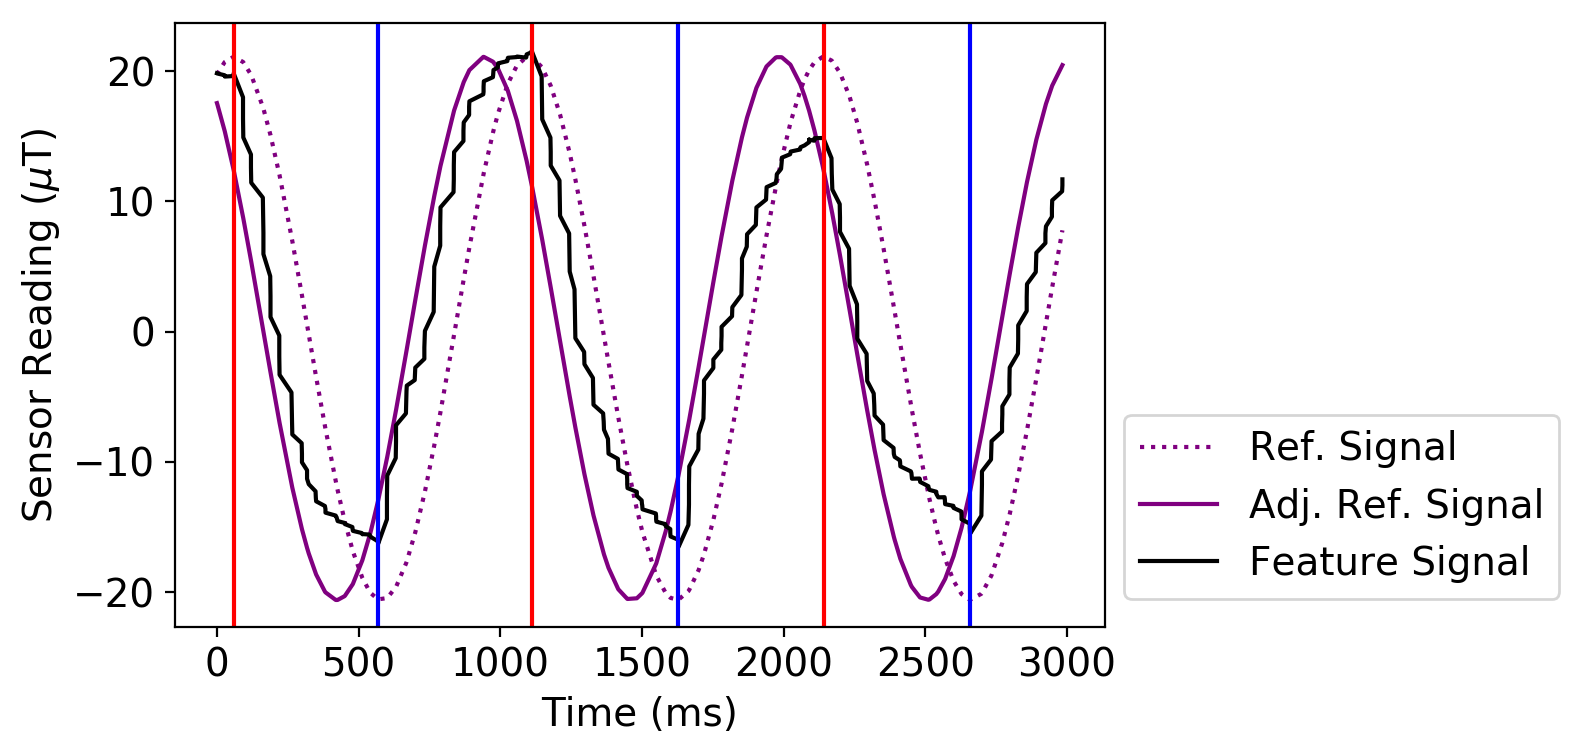

In [5]:
import pandas as pd
import matplotlib.pyplot as pplot
pairNum = 4
PLOT_SENSOR = "magnet"
FIT_SQUARE = False
def magv(v):
    return np.sqrt(v.dot(v))
def mag(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)
CORRELATION_EWMA = True
SHOW_CORRELATION_WINDOWS = True
def find_timeshift(a, b):
    shiftFactor = a.size - 1
    correlateIndex = np.argmax(correlate(a, b))
    return shiftFactor - correlateIndex
def delta_space_transform(leftVector, rightVector, currentVector, lastLeft):
    deltaVector = leftVector - rightVector
    currentDeltaVector = currentVector - leftVector if lastLeft else currentVector - rightVector
    scalarProjection = currentDeltaVector.dot(deltaVector) / magv(deltaVector)
    return scalarProjection
csvData = pd.read_csv("/media/jwpilly/PillowDisk/Research/Synchro/figuredata/figure7/p1_t1478897598685_xsitting1000_5_ssensorData.csv", names=['time','sensor','x','y','z','timestamp','linecounter',''])
valueX = []
valueY = []
valueZ = []
valueMag = []
valueT = []
valueTL = []
leftEvents = []
rightEvents = []
lx = 0
ly = 0
lz = 0
rx = 0
ry = 0
rz = 0
lastLeft = None
for rowI in range(len(csvData['sensor'])):
    row = csvData['sensor'][rowI]
    if row == PLOT_SENSOR:
        x = csvData['x'][rowI]
        y = csvData['y'][rowI]
        z = csvData['z'][rowI]
        t = csvData['time'][rowI]
        valueX.append((t, x))
        valueY.append((t, y))
        valueZ.append((t, z))
        valueMag.append((t, mag(x, y, z)))
        if lx != 0 and ly != 0 and lz != 0 and rx != 0 and ry != 0 and rz != 0:
            lV = np.array([lx, ly, lz])
            rV = np.array([rx, ry, rz])
            cV = np.array([x, y, z])
            tS = delta_space_transform(lV, rV, cV, False)
            tSL = delta_space_transform(lV, rV, cV, lastLeft)
            valueT.append((t, tS))
            valueTL.append((t, tSL))
    elif row == 'left':
        lx = x
        ly = y
        lz = z
        lastLeft = True
        leftEvents.append(t)
    elif row == 'right':
        rx = x
        ry = y
        rz = z
        lastLeft = False
        rightEvents.append(t)
valueX = np.array(valueX)
valueY = np.array(valueY)
valueZ = np.array(valueZ)
valueMag = np.array(valueMag)
valueT = np.array(valueT)
valueTL = np.array(valueTL)
signalPeriod = rightEvents[1] - rightEvents[0]
referenceSignal = lambda x : signal.square((2*np.pi/signalPeriod)*x + (1.57079633 - (2*np.pi/signalPeriod)*leftEvents[0])) if FIT_SQUARE else np.sin((2*np.pi/signalPeriod)*x + (1.57079633 - (2*np.pi/signalPeriod)*leftEvents[0])) # arcsin(1)
windowTime = signalPeriod * pairNum
valueS = valueTL
correlationCoefficients = []
skip = 2000
totalTime = leftEvents[-1] - leftEvents[0] - skip
waveLengths = [] 
for rowI in range(0, totalTime, totalTime // 5):
    startWindow = leftEvents[0] + skip
    endWindow = leftEvents[0] + rowI
#     print(startWindow, endWindow)
    window = []
    for v in valueS:
        valueTime = v[0]
        if valueTime >= startWindow and valueTime <= endWindow:
            window.append(v)
    if len(window) < 2:
        continue
    waveLengths.append(rowI)
#     print(len(window))
    window = np.array(window)
    generatedSignal = referenceSignal(window[:,0])
    actualSignal = remove_trend(window[:,1])
    signal_range = window[:,0]
    rfactor = signal_range.size * 2
    rs2 = resample(generatedSignal, rfactor, t=signal_range)
    ps2 = resample(actualSignal, rfactor, t=signal_range)
    ts2 = rs2[1]
    rs2 = rs2[0]
    ps2 = ps2[0]
    resample_time = (signal_range[-1] - signal_range[0]) / rfactor
    lag_factor = find_timeshift(rs2, ps2)
    lag_time = resample_time * lag_factor
    generatedSignal = signal.square((2*np.pi/signalPeriod)*signal_range + (1.57079633 - (2*np.pi/signalPeriod)*(leftEvents[0]+lag_time))) if FIT_SQUARE else np.sin((2*np.pi/signalPeriod)*signal_range + (1.57079633 - (2*np.pi/signalPeriod)*(leftEvents[0]+lag_time))) # arcsin(1)
    if CORRELATION_EWMA:
        actualSignal = get_ewma(actualSignal, alpha=0.1)
    cc = pearsonr(generatedSignal, actualSignal)
    correlationCoefficients.append(cc)
#     print("correlation for window ", rowI)
#     print(cc[0])
    if SHOW_CORRELATION_WINDOWS:
        if rowI != 5014:
            continue
        pplot.clf()
        f, (ax1) = pplot.subplots(1)
        ax1.set_xlabel("Time (ms)")
        ax1.set_ylabel("Sensor Reading (" + r'$\mu$T' + ")")
        actualRange = 0.2 * np.max(actualSignal) - np.min(actualSignal)
        ref_sig = ax1.plot(window[:,0] - np.min(window[:,0]), actualRange * np.array(referenceSignal(window[:,0])) + np.mean(actualSignal), color="purple", linestyle="dotted", label="Ref. Signal")
        adj_ref_sig = ax1.plot(window[:,0] - np.min(window[:,0]), actualRange * generatedSignal + np.mean(actualSignal), color="purple", label="Adj. Ref. Signal")
        feature_sig = ax1.plot(window[:,0] - np.min(window[:,0]), actualSignal, color="black", label="Feature Signal")
        for e in leftEvents:
            if e >= startWindow and e <= endWindow:
                ax1.axvline(x=e - np.min(window[:,0]), color="red")
        for e in rightEvents:
            if e >= startWindow and e <= endWindow:
                ax1.axvline(x=e - np.min(window[:,0]), color="blue")
        # for i in range(pairNum + 1):
        #     pplot.axvline(x=leftEvents[rowI + i], color='red')
        # for i in range(pairNum + 1):
        #     pplot.axvline(x=rightEvents[rowI + i], color='black')
#         pplot.legend(loc="best")
        pplot.legend(loc='center left', bbox_to_anchor=(1, 0.2))
        pplot.show()


## Figure 8

/home/jwpilly/anaconda3/envs/synchro/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


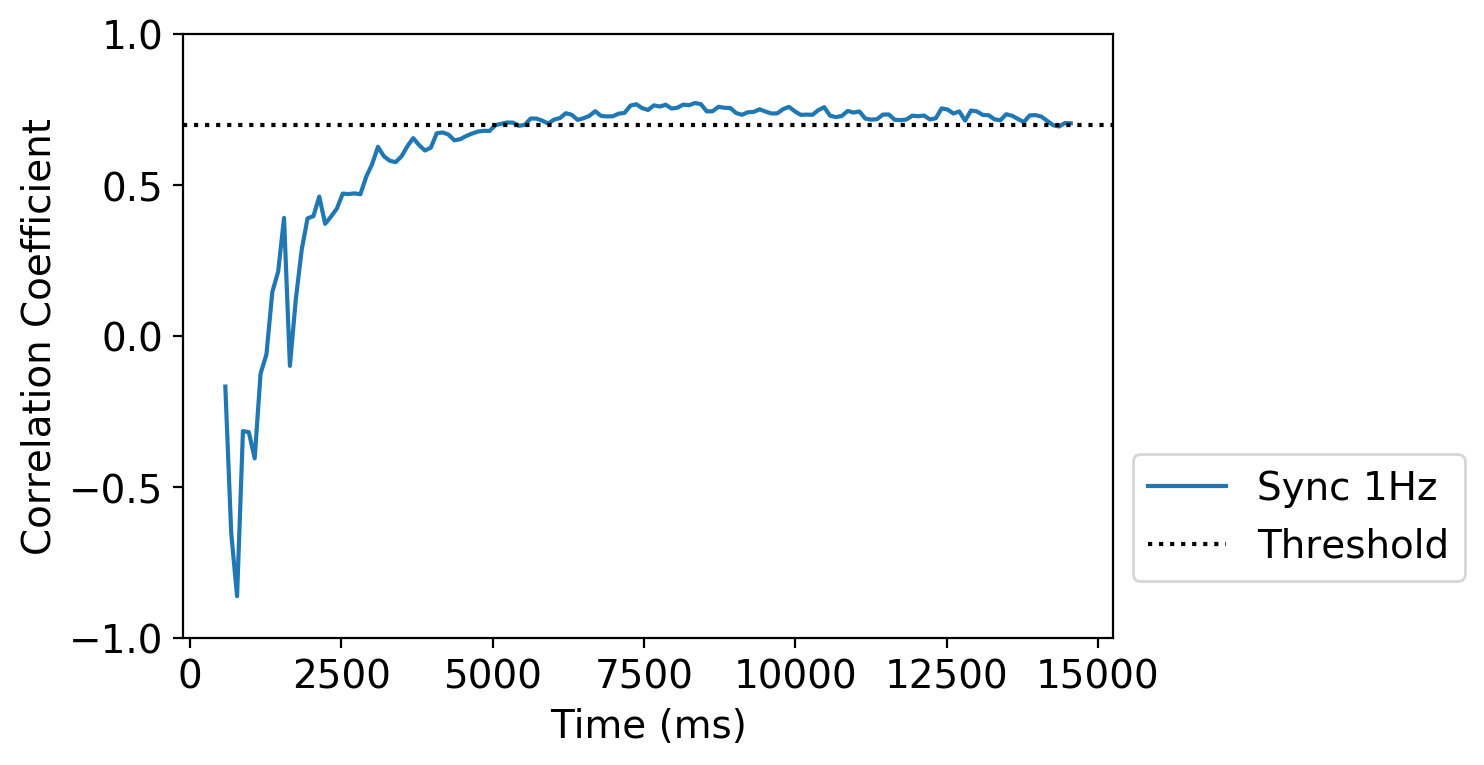

In [6]:
import pandas as pd
import matplotlib.pyplot as pplot
from scipy.signal import detrend
from scipy.signal import resample
pairNum = 4
PLOT_SENSOR = "magnet"
FIT_SQUARE = False
def get_ewma(df, alpha=1):
    # Compute alpha and exponential moving average
    span = (2-alpha)/alpha
    df_smooth = pd.ewma(df, span=span, adjust=False)
    return df_smooth
def remove_trend(x):
    return detrend(x)
def magv(v):
    return np.sqrt(v.dot(v))
def mag(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)
CORRELATION_EWMA = True
SHOW_CORRELATION_WINDOWS = True
def find_timeshift(a, b):
    shiftFactor = a.size - 1
    correlateIndex = np.argmax(correlate(a, b))
    return shiftFactor - correlateIndex
def delta_space_transform(leftVector, rightVector, currentVector, lastLeft):
    deltaVector = leftVector - rightVector
    currentDeltaVector = currentVector - leftVector if lastLeft else currentVector - rightVector
    scalarProjection = currentDeltaVector.dot(deltaVector) / magv(deltaVector)
    return scalarProjection
csvData = pd.read_csv("/media/jwpilly/PillowDisk/Research/Synchro/figuredata/figure8/p2_t1478805811109_xsitting1000_1_ssensorData.csv", names=['time','sensor','x','y','z','timestamp','linecounter',''])
valueX = []
valueY = []
valueZ = []
valueMag = []
valueT = []
valueTL = []
leftEvents = []
rightEvents = []
lx = 0
ly = 0
lz = 0
rx = 0
ry = 0
rz = 0
lastLeft = None
for rowI in range(len(csvData['sensor'])):
    row = csvData['sensor'][rowI]
    if row == PLOT_SENSOR:
        x = csvData['x'][rowI]
        y = csvData['y'][rowI]
        z = csvData['z'][rowI]
        t = csvData['time'][rowI]
        valueX.append((t, x))
        valueY.append((t, y))
        valueZ.append((t, z))
        valueMag.append((t, mag(x, y, z)))
        if lx != 0 and ly != 0 and lz != 0 and rx != 0 and ry != 0 and rz != 0:
            lV = np.array([lx, ly, lz])
            rV = np.array([rx, ry, rz])
            cV = np.array([x, y, z])
            tS = delta_space_transform(lV, rV, cV, False)
            tSL = delta_space_transform(lV, rV, cV, lastLeft)
            valueT.append((t, tS))
            valueTL.append((t, tSL))
    elif row == 'left':
        lx = x
        ly = y
        lz = z
        lastLeft = True
        leftEvents.append(t)
    elif row == 'right':
        rx = x
        ry = y
        rz = z
        lastLeft = False
        rightEvents.append(t)
valueX = np.array(valueX)
valueY = np.array(valueY)
valueZ = np.array(valueZ)
valueMag = np.array(valueMag)
valueT = np.array(valueT)
valueTL = np.array(valueTL)
signalPeriod = rightEvents[1] - rightEvents[0]
referenceSignal = lambda x : signal.square((2*np.pi/signalPeriod)*x + (1.57079633 - (2*np.pi/signalPeriod)*leftEvents[0])) if FIT_SQUARE else np.sin((2*np.pi/signalPeriod)*x + (1.57079633 - (2*np.pi/signalPeriod)*leftEvents[0])) # arcsin(1)
windowTime = signalPeriod * pairNum
valueS = valueTL
correlationCoefficients = []
skip = 0
totalTime = leftEvents[-1] - leftEvents[0] - skip
waveLengths = [] 
for rowI in range(0, totalTime, totalTime // 150):
    startWindow = leftEvents[0] + skip
    endWindow = leftEvents[0] + rowI
#     print(startWindow, endWindow)
    window = []
    for v in valueS:
        valueTime = v[0]
        if valueTime >= startWindow and valueTime <= endWindow:
            window.append(v)
    if len(window) < 2:
        continue
    waveLengths.append(rowI)
#     print(len(window))
    window = np.array(window)
    generatedSignal = referenceSignal(window[:,0])
    actualSignal = remove_trend(window[:,1])
    signal_range = window[:,0]
    rfactor = signal_range.size * 2
    rs2 = resample(generatedSignal, rfactor, t=signal_range)
    ps2 = resample(actualSignal, rfactor, t=signal_range)
    ts2 = rs2[1]
    rs2 = rs2[0]
    ps2 = ps2[0]
    resample_time = (signal_range[-1] - signal_range[0]) / rfactor
    lag_factor = find_timeshift(rs2, ps2)
    lag_time = resample_time * lag_factor
    generatedSignal = signal.square((2*np.pi/signalPeriod)*signal_range + (1.57079633 - (2*np.pi/signalPeriod)*(leftEvents[0]+lag_time))) if FIT_SQUARE else np.sin((2*np.pi/signalPeriod)*signal_range + (1.57079633 - (2*np.pi/signalPeriod)*(leftEvents[0]+lag_time))) # arcsin(1)
    if CORRELATION_EWMA:
        actualSignal = get_ewma(actualSignal, alpha=0.1)
    cc = pearsonr(generatedSignal, actualSignal)
    correlationCoefficients.append(cc)

correlationCoefficients = np.array(correlationCoefficients)
pplot.clf()
pax = pplot.gca()
pax.set_ylim(-1, 1)
pax.set_xlabel("Time (ms)")
pax.set_ylabel("Correlation Coefficient")
pplot.plot(np.array(waveLengths), correlationCoefficients[:,0], label="Sync 1Hz")
pplot.axhline(y=0.7, color="black", linestyle="dotted", label="Threshold")
# pplot.legend(loc="lower right")
pplot.legend(loc='center left', bbox_to_anchor=(1, 0.2))
pplot.show()

## Figure 10

frequency ('750', 'red')
frequency ('1000', 'green')
frequency ('1250', 'blue')


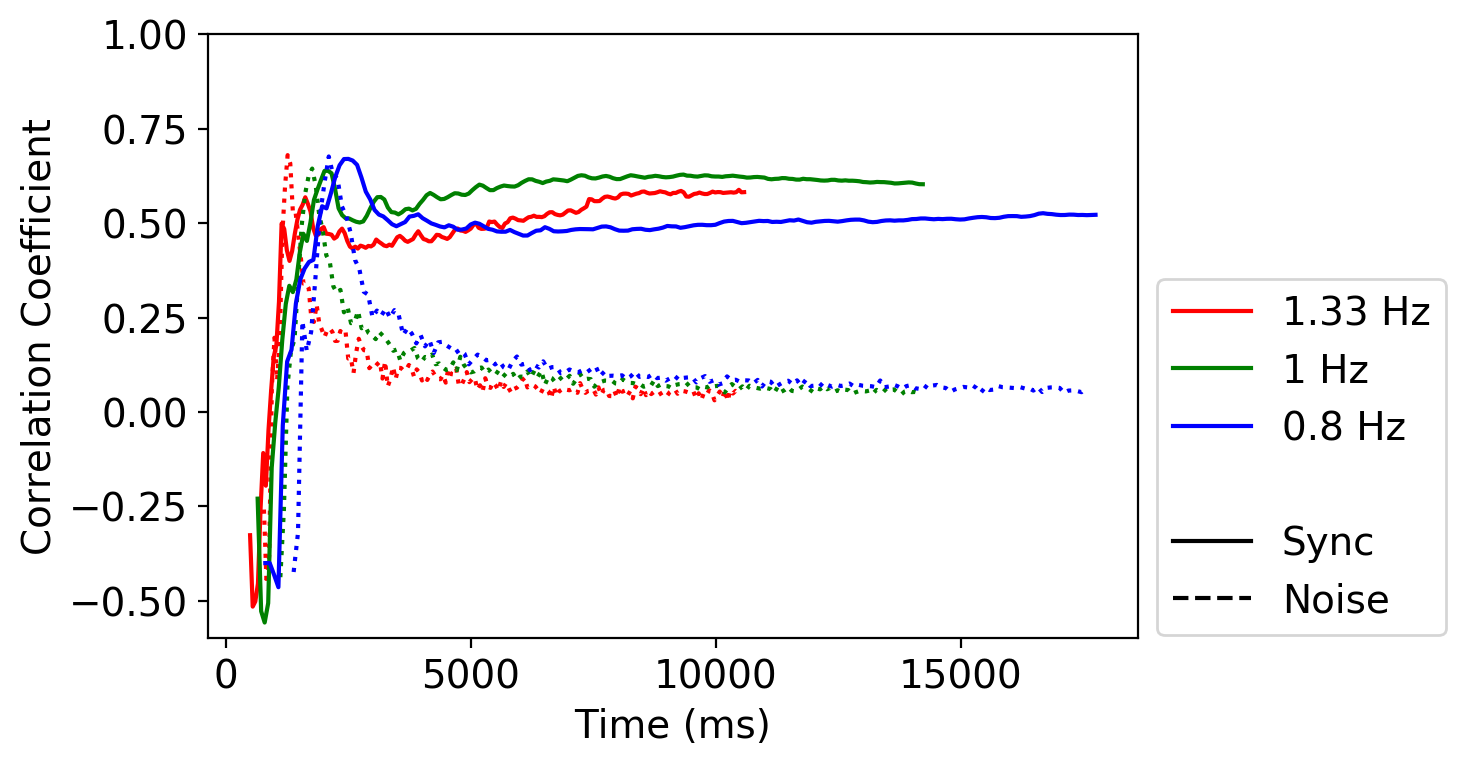

In [7]:
import pandas as pd
import matplotlib.pyplot as pplot
from io import StringIO
GROUP_FREQUENCY = "1000" 
NUM_STEPS = 200
TARGET_DIR = "/media/jwpilly/PillowDisk/Research/Synchro/figuredata/figure10/User Study/Raw/"
NOISE_FILE = "/media/jwpilly/PillowDisk/Research/Synchro/figuredata/figure10/User Study/allnoise.csv"
SKIP_CYCLES = 0
DATA_ROW_LENGTH = 8
DATA_LINE_COUNTER_INDEX = 6
DATA_TIMESTAMP_INDEX = 0
DATA_SENSOR_INDEX = 1
DATA_SENSOR_DATA_START = 2
DATA_SENSOR_DATA_END = 4
FIT_SAW = False
def get_random_data(noiseData, length, randomContinuous=True):
    randomData = []
    if randomContinuous:
        startIndex = random.randint(0, len(noiseData) - length - 1)
        while True:
            startRow = noiseData[startIndex]
            startRowColumns = startRow.split(",")
            if len(startRowColumns) != DATA_ROW_LENGTH:
                startIndex = random.randint(0, len(noiseData) - length - 1)
                continue
            endIndex = startIndex + length - 1
            endRow = noiseData[endIndex]
            endRowColumns = endRow.split(",")
            if len(endRowColumns) != DATA_ROW_LENGTH or int(endRowColumns[DATA_LINE_COUNTER_INDEX]) - int(startRowColumns[DATA_LINE_COUNTER_INDEX]) != length - 1:
                startIndex = random.randint(0, len(noiseData) - length - 1)
            else:
                break
        for i in range(length):
            rowIndex = startIndex + i
            randomData.append(noiseData[rowIndex])
    else:
        startIndex = random.randint(0, len(noiseData) - length - 1)
        indexOffset = 0
        while len(randomData) < length:
            currentRow = noiseData[startIndex + indexOffset]
            currentRowColumns = currentRow.split(",")
            if len(currentRowColumns) != DATA_ROW_LENGTH:
                startIndex = random.randint(0, len(noiseData) - length - 1)
                indexOffset = 0
            else:
                startLineCounter = int(noiseData[startIndex].split(",")[DATA_LINE_COUNTER_INDEX])
                currentLineCounter = int(noiseData[startIndex + indexOffset].split(",")[DATA_LINE_COUNTER_INDEX])
                if currentLineCounter - startLineCounter == indexOffset:
                    randomData.append(currentRow)
                    indexOffset += 1
                else:
                    startIndex = random.randint(0, len(noiseData) - length - 1)
                    indexOffset = 0
        for i in range(length):
            rowIndex = startIndex + i
            noiseRow = noiseData[rowIndex]
            randomData.append(noiseRow)
    return randomData
def insert_timer_ticks(noiseData, interval):
    noiseDataCopy = noiseData[:]
    currentTick = "left"
    insertOffset = 0
    lastTick = 0
    for rowI in range(len(noiseData)):
        currentRow = noiseData[rowI]
        currentRowColumns = currentRow.split(",")
        if len(currentRowColumns) != DATA_ROW_LENGTH:
            continue
        currentRowTime = int(currentRowColumns[DATA_TIMESTAMP_INDEX])
        if lastTick == 0 or (currentRowTime - lastTick) >= interval:
            if lastTick != 0:
                tickRow = str(currentRowTime) + "," + currentTick + ",\n"
                noiseDataCopy.insert(rowI + insertOffset, tickRow)
                insertOffset += 1
                if currentTick == "left":
                    currentTick = "right"
                else:
                    currentTick = "left"
            lastTick = currentRowTime
    return noiseDataCopy

def data_correlation_graphs2_noise(csvData):
#     print("csvData", csvData)
    # valueX = []
    # valueY = []
    # valueZ = []
    # valueMag = []
    # valueT = []
    # valueTL = []
    rleftEvents = []
    rrightEvents = []
    # lx = 0
    # ly = 0
    # lz = 0
    # rx = 0
    # ry = 0
    # rz = 0
    # lastLeft = None
    for rowI in range(len(csvData['sensor'])):
        row = csvData['sensor'][rowI]
        if row == PLOT_SENSOR:
            x = csvData['x'][rowI]
            y = csvData['y'][rowI]
            z = csvData['z'][rowI]
            t = csvData['time'][rowI]
            # valueX.append((t, x))
            # valueY.append((t, y))
            # valueZ.append((t, z))
            # valueMag.append((t, mag(x, y, z)))
            # if lx != 0 and ly != 0 and lz != 0 and rx != 0 and ry != 0 and rz != 0:
            #     lV = np.array([lx, ly, lz])
            #     rV = np.array([rx, ry, rz])
            #     cV = np.array([x, y, z])
            #     tS = delta_space_transform(lV, rV, cV, False)
            #     tSL = delta_space_transform(lV, rV, cV, lastLeft)
            #     valueT.append((t, tS))
            #     valueTL.append((t, tSL))
        elif row == 'left':
            lx = x
            ly = y
            lz = z
            lastLeft = True
            rleftEvents.append(t)
        elif row == 'right':
            rx = x
            ry = y
            rz = z
            lastLeft = False
            rrightEvents.append(t)
    # valueX = np.aray(valueX)
    # valueY = np.array(valueY)
    # valueZ = np.array(valueZ)
    # valueMag = np.array(valueMag)
    # valueT = np.array(valueT)
    # valueTL = np.array(valueTL)
    signalPeriod = rrightEvents[1] - rrightEvents[0]
    # print("FIT_SAW", FIT_SAW)
    # referenceSignal = lambda x : signal.sawtooth((2*np.pi/signalPeriod)*x + (1.57079633 - (2*np.pi/signalPeriod)*leftEvents[0]), width=0.5) if FIT_SAW else np.sin((2*np.pi/signalPeriod)*x + (1.57079633 - (2*np.pi/signalPeriod)*leftEvents[0])) # arcsin(1)
    # windowTime = signalPeriod * pairNum
    # valueS = valueTL
    correlationCoefficients = []
    discardNum = SKIP_CYCLES 
    totalTime = int(rleftEvents[-1] - (rleftEvents[0] + discardNum*signalPeriod))
    waveLengths = [] 
    for rowI in range(0, totalTime, totalTime // NUM_STEPS):
#         print(rowI, "/", totalTime)
        noise_chunk = insert_timer_ticks(get_random_data(csvNoiseSensorData, rowI,True), int(GROUP_FREQUENCY))
        noiseData = pd.read_csv(StringIO("\n".join(noise_chunk)), names=['time','sensor','x','y','z','timestamp','linecounter',''])
        valueX = []
        valueY = []
        valueZ = []
        valueMag = []
        valueT = []
        valueTL = []
        leftEvents = []
        rightEvents = []
        lx = 0
        ly = 0
        lz = 0
        rx = 0
        ry = 0
        rz = 0
        lastLeft = None
        for rowI in range(len(noiseData['sensor'])):
            row = noiseData['sensor'][rowI]
            if row == PLOT_SENSOR:
                x = noiseData['x'][rowI]
                y = noiseData['y'][rowI]
                z = noiseData['z'][rowI]
                t = noiseData['time'][rowI]
                valueX.append((t, x))
                valueY.append((t, y))
                valueZ.append((t, z))
                valueMag.append((t, mag(x, y, z)))
                if lx != 0 and ly != 0 and lz != 0 and rx != 0 and ry != 0 and rz != 0:
                    lV = np.array([lx, ly, lz])
                    rV = np.array([rx, ry, rz])
                    cV = np.array([x, y, z])
                    tS = delta_space_transform(lV, rV, cV, False)
                    tSL = delta_space_transform(lV, rV, cV, lastLeft)
                    valueT.append((t, tS))
                    valueTL.append((t, tSL))
            elif row == 'left':
                lx = x
                ly = y
                lz = z
                lastLeft = True
                leftEvents.append(t)
            elif row == 'right':
                rx = x
                ry = y
                rz = z
                lastLeft = False
                rightEvents.append(t)
        valueX = np.array(valueX)
        valueY = np.array(valueY)
        valueZ = np.array(valueZ)
        valueMag = np.array(valueMag)
        valueT = np.array(valueT)
        valueTL = np.array(valueTL)
        valueS = valueTL
        referenceSignal = lambda x : signal.sawtooth((2*np.pi/signalPeriod)*x + (1.57079633 - (2*np.pi/signalPeriod)*leftEvents[0]), width=0.5) if FIT_SAW else np.sin((2*np.pi/signalPeriod)*x + (1.57079633 - (2*np.pi/signalPeriod)*leftEvents[0])) # arcsin(1)
        windowTime = signalPeriod * pairNum
        window = []
        skipCount = 0
        for v in valueS:
            # valueTime = v[0]
            # if valueTime >= startWindow and valueTime <= endWindow:
            #     window.append(v)
            if np.any(np.isnan(v)) or np.any(np.isinf(v)):
                continue
            window.append(v)
        if len(window) < 2:
            skipCount += 1
            continue
#         print("skipped", skipCount)
        waveLengths.append(rowI)
        window = np.array(window)
        generatedSignal = referenceSignal(window[:,0])
        actualSignal = remove_trend(window[:,1])
        signal_range = window[:,0]
        rfactor = signal_range.size * 2
        rs2 = resample(generatedSignal, rfactor, t=signal_range)
        ps2 = resample(actualSignal, rfactor, t=signal_range)
        ts2 = rs2[1]
        rs2 = rs2[0]
        ps2 = ps2[0]
        resample_time = (signal_range[-1] - signal_range[0]) / rfactor
        lag_factor = find_timeshift(rs2, ps2)
        lag_time = resample_time * lag_factor
        generatedSignal = signal.sawtooth((2*np.pi/signalPeriod)*signal_range + (1.57079633 - (2*np.pi/signalPeriod)*(leftEvents[0]+lag_time)), width=0.5) if FIT_SAW else np.sin((2*np.pi/signalPeriod)*signal_range + (1.57079633 - (2*np.pi/signalPeriod)*(leftEvents[0]+lag_time))) # arcsin(1)
        if CORRELATION_EWMA:
            actualSignal = get_ewma(actualSignal, alpha=0.1)
        cc = pearsonr(generatedSignal, actualSignal)
        correlationCoefficients.append((rowI, cc[0]))
    correlationCoefficients = np.array(correlationCoefficients)
    return correlationCoefficients

def data_correlation_graphs2(csvData):
    valueX = []
    valueY = []
    valueZ = []
    valueMag = []
    valueT = []
    valueTL = []
    leftEvents = []
    rightEvents = []
    lx = 0
    ly = 0
    lz = 0
    rx = 0
    ry = 0
    rz = 0
    lastLeft = None
    for rowI in range(len(csvData['sensor'])):
        row = csvData['sensor'][rowI]
        if row == PLOT_SENSOR:
            x = csvData['x'][rowI]
            y = csvData['y'][rowI]
            z = csvData['z'][rowI]
            t = csvData['time'][rowI]
            valueX.append((t, x))
            valueY.append((t, y))
            valueZ.append((t, z))
            valueMag.append((t, mag(x, y, z)))
            if lx != 0 and ly != 0 and lz != 0 and rx != 0 and ry != 0 and rz != 0:
                lV = np.array([lx, ly, lz])
                rV = np.array([rx, ry, rz])
                cV = np.array([x, y, z])
                tS = delta_space_transform(lV, rV, cV, False)
                tSL = delta_space_transform(lV, rV, cV, lastLeft)
                valueT.append((t, tS))
                valueTL.append((t, tSL))
        elif row == 'left':
            lx = x
            ly = y
            lz = z
            lastLeft = True
            leftEvents.append(t)
        elif row == 'right':
            rx = x
            ry = y
            rz = z
            lastLeft = False
            rightEvents.append(t)
    valueX = np.array(valueX)
    valueY = np.array(valueY)
    valueZ = np.array(valueZ)
    valueMag = np.array(valueMag)
    valueT = np.array(valueT)
    valueTL = np.array(valueTL)
    signalPeriod = rightEvents[1] - rightEvents[0]
#     print("FIT_SAW", FIT_SAW)
    referenceSignal = lambda x : signal.sawtooth((2*np.pi/signalPeriod)*x + (1.57079633 - (2*np.pi/signalPeriod)*leftEvents[0]), width=0.5) if FIT_SAW else np.sin((2*np.pi/signalPeriod)*x + (1.57079633 - (2*np.pi/signalPeriod)*leftEvents[0])) # arcsin(1)
    windowTime = signalPeriod * pairNum
    valueS = valueTL
    correlationCoefficients = []
    discardNum = SKIP_CYCLES 
    totalTime = int(leftEvents[-1] - (leftEvents[0] + discardNum*signalPeriod))
    waveLengths = [] 
    for rowI in range(0, totalTime, totalTime // NUM_STEPS):
        startWindow = leftEvents[0] + discardNum*signalPeriod
        endWindow = leftEvents[0] + rowI
        window = []
        for v in valueS:
            valueTime = v[0]
            if valueTime >= startWindow and valueTime <= endWindow:
                window.append(v)
        if len(window) < 2:
            continue
        waveLengths.append(rowI)
        window = np.array(window)
        generatedSignal = referenceSignal(window[:,0])
        actualSignal = remove_trend(window[:,1])
        signal_range = window[:,0]
        rfactor = signal_range.size * 2
        rs2 = resample(generatedSignal, rfactor, t=signal_range)
        ps2 = resample(actualSignal, rfactor, t=signal_range)
        ts2 = rs2[1]
        rs2 = rs2[0]
        ps2 = ps2[0]
        resample_time = (signal_range[-1] - signal_range[0]) / rfactor
        lag_factor = find_timeshift(rs2, ps2)
        lag_time = resample_time * lag_factor
        generatedSignal = signal.sawtooth((2*np.pi/signalPeriod)*signal_range + (1.57079633 - (2*np.pi/signalPeriod)*(leftEvents[0]+lag_time)), width=0.5) if FIT_SAW else np.sin((2*np.pi/signalPeriod)*signal_range + (1.57079633 - (2*np.pi/signalPeriod)*(leftEvents[0]+lag_time))) # arcsin(1)
        if CORRELATION_EWMA:
            actualSignal = get_ewma(actualSignal, alpha=0.1)
        cc = pearsonr(generatedSignal, actualSignal)
        correlationCoefficients.append((rowI, cc[0]))
    correlationCoefficients = np.array(correlationCoefficients)
    return correlationCoefficients
def initialize_environment():
    global csvSensorDatas
    global csvNoiseSensorData
    global GROUP_FREQUENCY
    cmd = r'find "' + TARGET_DIR + r'" -name "*"' + GROUP_FREQUENCY + r'"*ssensorData.csv" | grep -v "noise"'
    import subprocess
    csvSensorDataFiles = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE).stdout.read().decode('utf-8').split('\n')[:-1]
    csvSensorDatas = []
    for f in csvSensorDataFiles:
        csvSensorData = pd.read_csv(f, names=['time','sensor','x','y','z','timestamp','linecounter',''])
        csvSensorDatas.append(csvSensorData)

    # csvNoiseSensorData = pd.read_csv(NOISE_FILE, names=['time','sensor','x','y','z','timestamp','linecounter',''])
    csvNoiseSensorData = open(NOISE_FILE).readlines()
def plot_category(ax, category, category_color):
    CF = "plot_category_" + category + "_" + category_color + ".npy"
    if os.path.isfile(CF):
        avgCCs = np.load(CF)
    else:
        global GROUP_FREQUENCY
        GROUP_FREQUENCY = category
        initialize_environment()
        mcs = []
        for sdi in range(len(csvSensorDatas)):
    #         print("(actual) sensor file", sdi,"/", len(csvSensorDatas))
            sd = csvSensorDatas[sdi]
            mc = data_correlation_graphs2(sd)
            mcs.append(mc)

        minLength = min([i.shape[0] for i in mcs])
        mcs = [cc[:minLength] for cc in mcs]
        avgCCs = np.array(mcs).mean(axis=0)
        np.save(CF, avgCCs)
    ax1.plot(avgCCs[:,0], avgCCs[:,1], color=category_color)


def plot_category_noise(ax, category, category_color):
    CF = "plot_category_noise_" + category + "_" + category_color + ".npy"
    if os.path.isfile(CF):
        avgCCs = np.load(CF)
    else:
        global GROUP_FREQUENCY
        GROUP_FREQUENCY = category
        initialize_environment()
        mcs = []
        for sdi in range(len(csvSensorDatas)):
    #         print("(noise) sensor file", sdi,"/", len(csvSensorDatas))
            sd = csvSensorDatas[sdi]
            mc = data_correlation_graphs2_noise(sd)
            mcs.append(mc)

        minLength = min([i.shape[0] for i in mcs])
        mcs = [cc[:minLength] for cc in mcs]
        avgCCs = np.array(mcs).mean(axis=0)
        np.save(CF, avgCCs)
    ax1.plot(avgCCs[:,0], avgCCs[:,1], color=category_color, linestyle="dotted")

f, (ax1) = pplot.subplots(1)

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Correlation Coefficient")
frequencies = [("750", "red"), ("1000", "green"), ("1250", "blue")]
for freq in frequencies:
    print("frequency", freq)
    plot_category_noise(ax1, freq[0], freq[1])
    plot_category(ax1, freq[0], freq[1])
    
ax1.plot([], [], color="red", label="1.33 Hz")
ax1.plot([], [], color="green", label="1 Hz")
ax1.plot([], [], color="blue", label="0.8 Hz")
ax1.plot(np.NaN, np.NaN, '-', color='none', label='    ')
ax1.plot([], [], color="black", label="Sync")
ax1.plot([], [], color="black", label="Noise", linestyle="dashed")
pax = pplot.gca()
pax.set_ylim([-0.6, 1.0])
# pplot.legend()
pplot.legend(loc='center left', bbox_to_anchor=(1, 0.3))
pplot.show()

## Figure 12

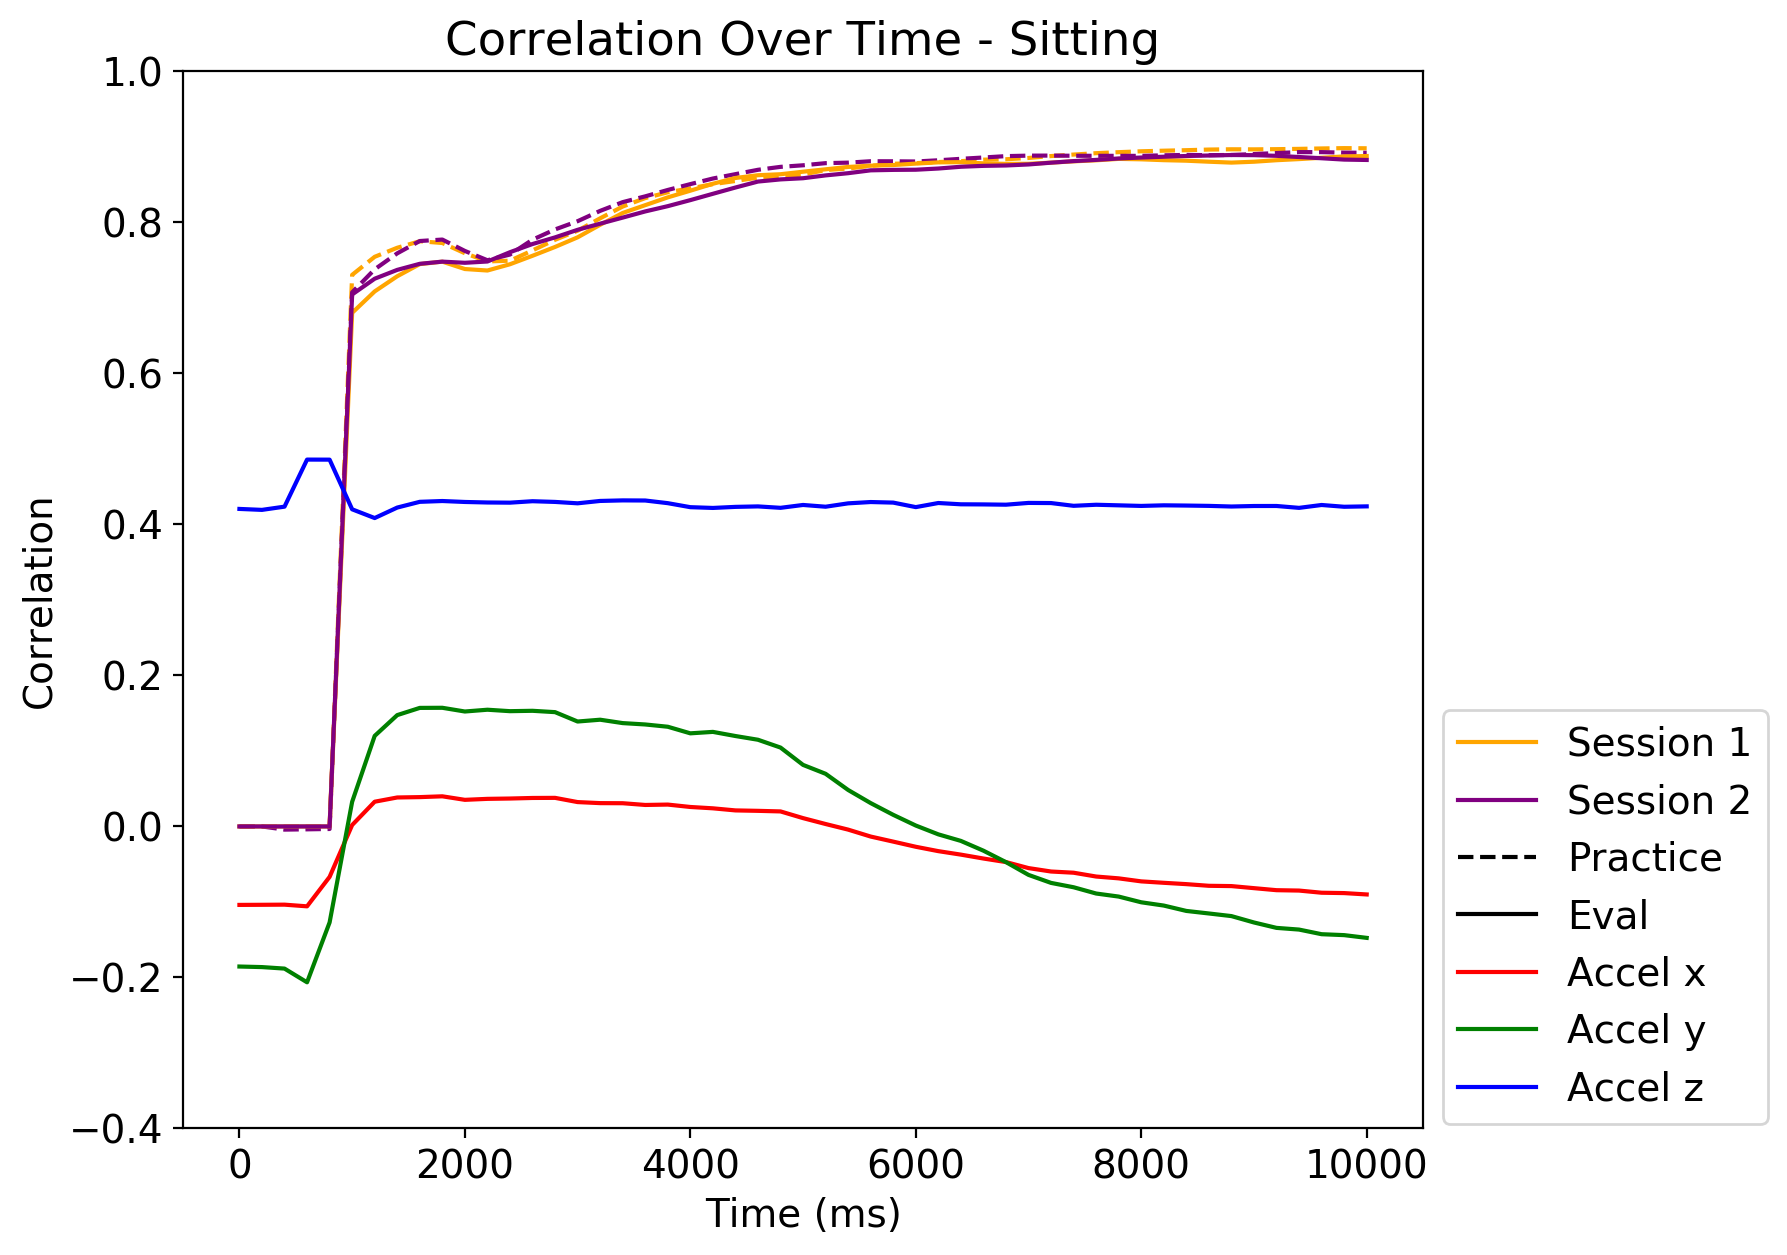

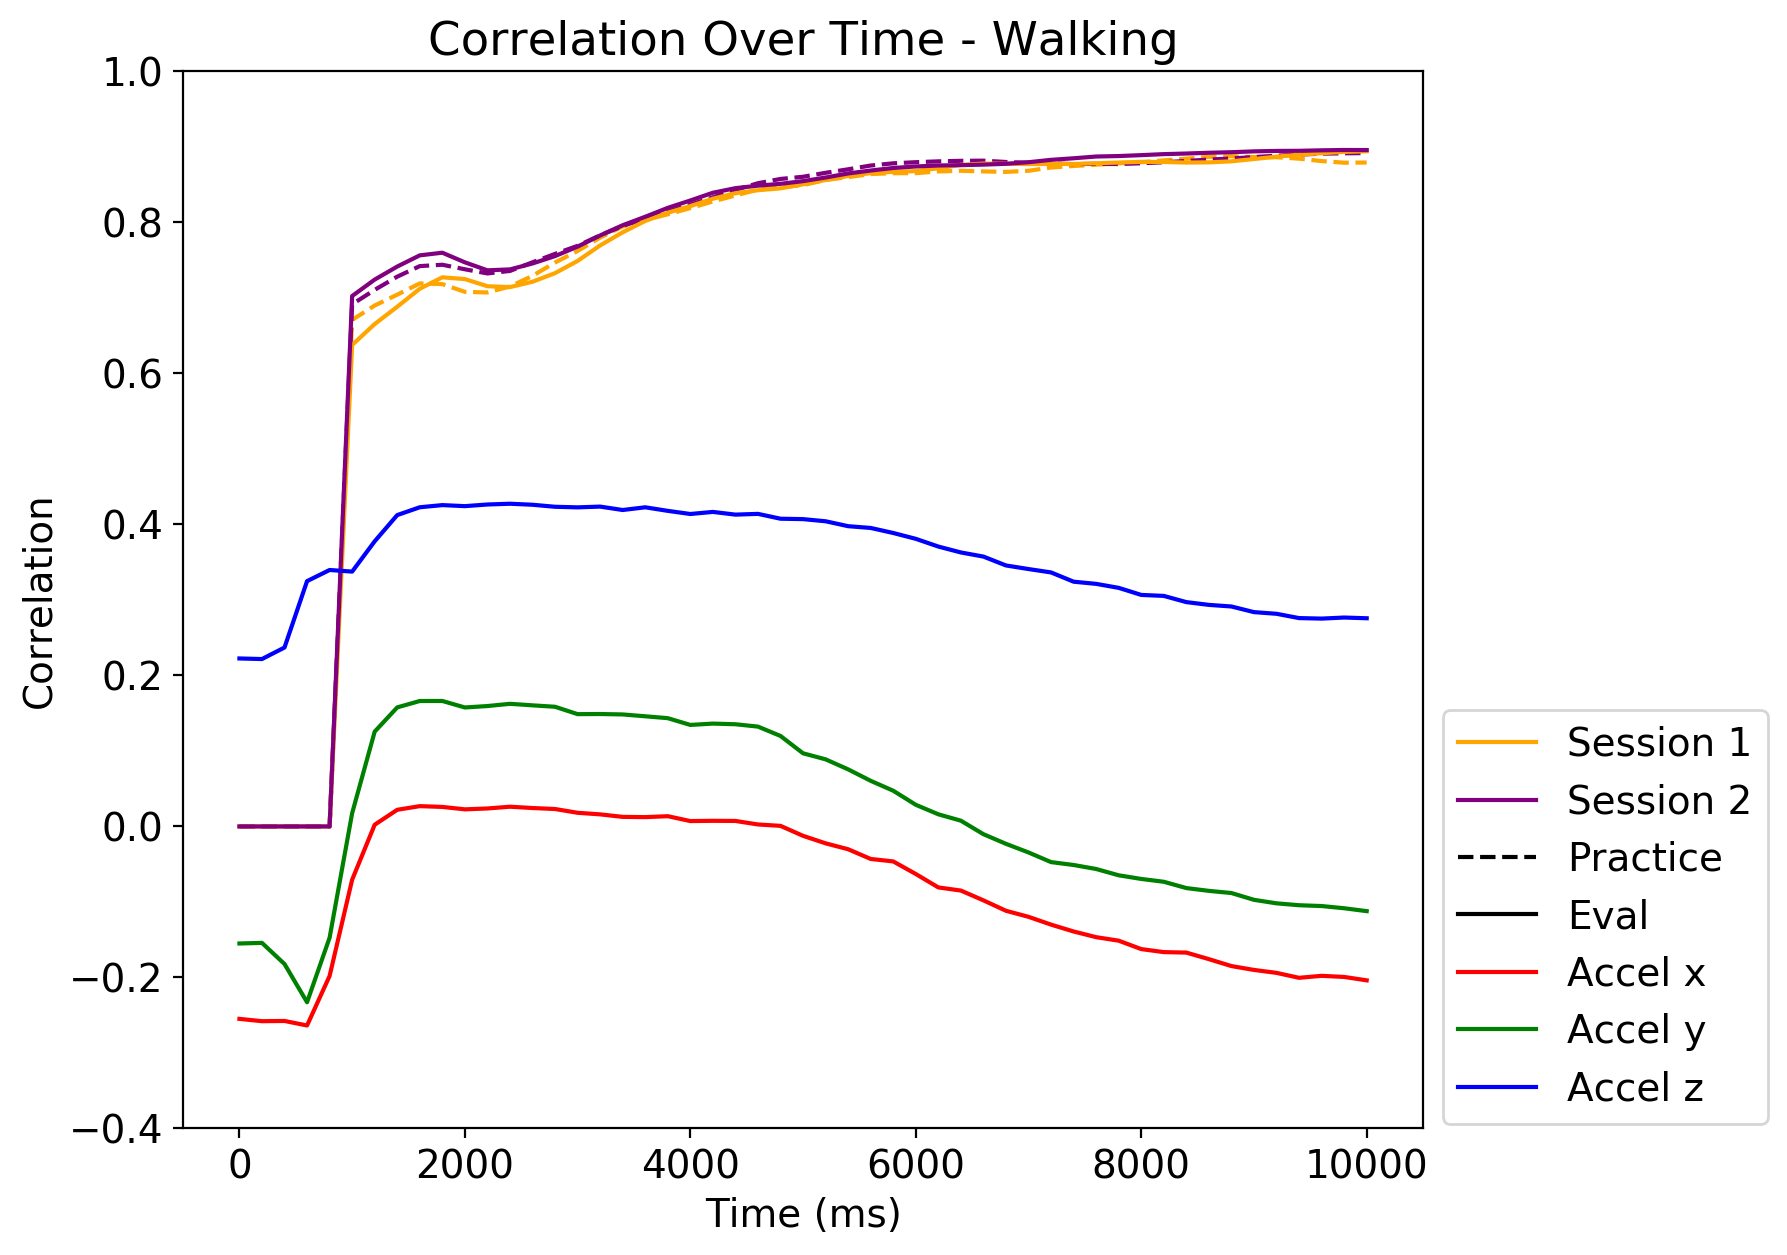

In [26]:
import os.path
import numpy as np


def figure12():
    CF = "figure12_paverages.npy"
    if os.path.isfile(CF):
        paverages = np.load(CF)
    else:
        # this block iterates through the study data and calculates the data needed for the correlation over time graph with accel

        from functools import reduce

        # baseFilePath = "/Users/jwpilly/Documents/Research/Synchro/Study_v2/"
        baseFilePath = "/media/jwpilly/PillowDisk/Research/Synchro/figuredata/figure12/Study_v2"
        # baseFilePath = "/home/jwpilly/Downloads/Studyv2Backup/studyv2backup"
        presults = []
        for root, folders, files in os.walk(baseFilePath):
            if not root.endswith("synchro") or "MACOSX" in root:
                continue
            print(root)
            sfolders = sorted(folders, key=lambda x : int(x.split("_")[0].replace("t", "")))
            efolders = [f for f in sfolders[:] if "prep" not in f]
            efolderpaths = [root + "/" + f + "/" for f in efolders]
        #     print(efolderpaths)
            efoldertimes = [(efolderpaths[i].split("_")[-1][:-1] + str(i), correlateSyncAccelFile(efolderpaths[i], noise=False, output=False)) for i in range(len(efolderpaths))]
        #     print(efoldertimes)
            presults.append(efoldertimes)
        presultsa = [[i[1] for i in t] for t in [sorted(r) for r in presults]]

        paverages = reduce(lambda x, y : np.array(x) + np.array(y), presultsa) / len(presultsa)
        np.save(CF, paverages)

    # this block generates the graph for the correlation over time graphs with accel. depending on which block was run before this, it is for sync/noise

    plt.clf()
    plt.figure(figsize=(8,7))
    # x = corr_times / 1000
    x = corr_times
    # figure = plt.figure(figsize=(15, 7))
    # figure.add_subplot(121)
    plt.title("Correlation Over Time - Sitting")
    plt.xlabel("Time (ms)")
    plt.ylabel("Correlation")
    plt.ylim(-0.4, 1)
    # plt.xlim(0, 10000)
    plt.plot([], [], color="orange", label="Session 1")
    plt.plot([], [], color="purple", label="Session 2")
#     plt.plot(np.NaN, np.NaN, '-', color='none', label='    ')
    plt.plot([], [], color="black", linestyle="dashed", label="Practice")
    plt.plot([], [], color="black", linestyle="solid", label="Eval")
#     plt.plot(np.NaN, np.NaN, '-', color='none', label='    ')
    plt.plot(x, [paverages[0][0][i] for i in range(len(x))], linestyle="dashed", color="orange")
    plt.plot(x, [paverages[1][0][i] for i in range(len(x))], linestyle="dashed", color="purple")
    plt.plot(x, [paverages[2][0][i] for i in range(len(x))], color="orange")
    plt.plot(x, [paverages[3][0][i] for i in range(len(x))], color="purple")
    plt.plot(x, np.mean([paverages[pi][1][0] for pi in range(len(paverages) // 2)], axis=0) / np.ptp([paverages[pi][1][0] for pi in range(len(paverages))]) / 2, label="Accel x", color="red")
    plt.plot(x, np.mean([paverages[pi][1][1] for pi in range(len(paverages) // 2)], axis=0) / np.ptp([paverages[pi][1][1] for pi in range(len(paverages))]) / 2, label="Accel y", color="green")
    plt.plot(x, np.mean([paverages[pi][1][2] for pi in range(len(paverages) // 2)], axis=0) / np.ptp([paverages[pi][1][2] for pi in range(len(paverages))]) / 2, label="Accel z", color="blue")

    # plt.legend(loc="best")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.2))
    # plt.savefig("correlation_over_time_accel_1.png", bbox_inches="tight")
    plt.show()
    # figure.add_subplot(122)
    plt.clf()
    plt.figure(figsize=(8,7))
    plt.title("Correlation Over Time - Walking")
    plt.xlabel("Time (ms)")
    plt.ylabel("Correlation")
    plt.ylim(-0.4, 1)
    # plt.xlim(0, 10000)
    plt.plot([], [], color="orange", label="Session 1")
    plt.plot([], [], color="purple", label="Session 2")
#     plt.plot(np.NaN, np.NaN, '-', color='none', label='    ')
    plt.plot([], [], color="black", linestyle="dashed", label="Practice")
    plt.plot([], [], color="black", linestyle="solid", label="Eval")
#     plt.plot(np.NaN, np.NaN, '-', color='none', label='    ')
    plt.plot(x, [paverages[4][0][i] for i in range(len(x))], linestyle="dashed", color="orange")
    plt.plot(x, [paverages[5][0][i] for i in range(len(x))], linestyle="dashed", color="purple")
    plt.plot(x, [paverages[6][0][i] for i in range(len(x))], color="orange")
    plt.plot(x, [paverages[7][0][i] for i in range(len(x))], color="purple")
    plt.plot(x, np.mean([paverages[pi][1][0] for pi in range(len(paverages) // 2 + 4)], axis=0) / np.ptp([paverages[pi][1][0] for pi in range(len(paverages))]) / 2, label="Accel x", color="red")
    plt.plot(x, np.mean([paverages[pi][1][1] for pi in range(len(paverages) // 2 + 4)], axis=0) / np.ptp([paverages[pi][1][1] for pi in range(len(paverages))]) / 2, label="Accel y", color="green")
    plt.plot(x, np.mean([paverages[pi][1][2] for pi in range(len(paverages) // 2 + 4)], axis=0) / np.ptp([paverages[pi][1][2] for pi in range(len(paverages))]) / 2, label="Accel z", color="blue")

    # plt.legend(loc="best")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.2))
    # plt.savefig("correlation_over_time_accel_2.png", bbox_inches="tight")
    plt.show()

figure12()

## Figure 14

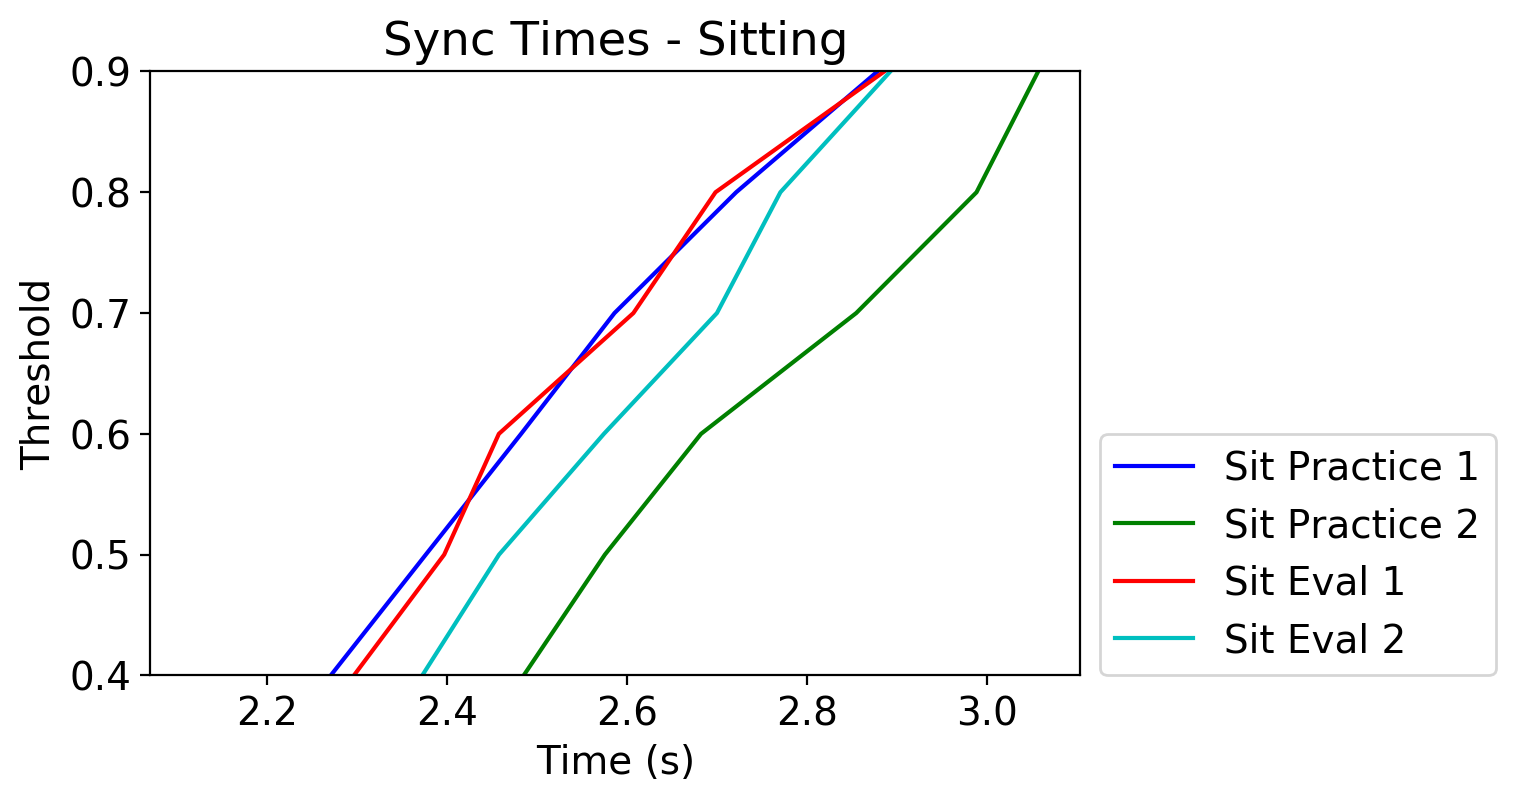

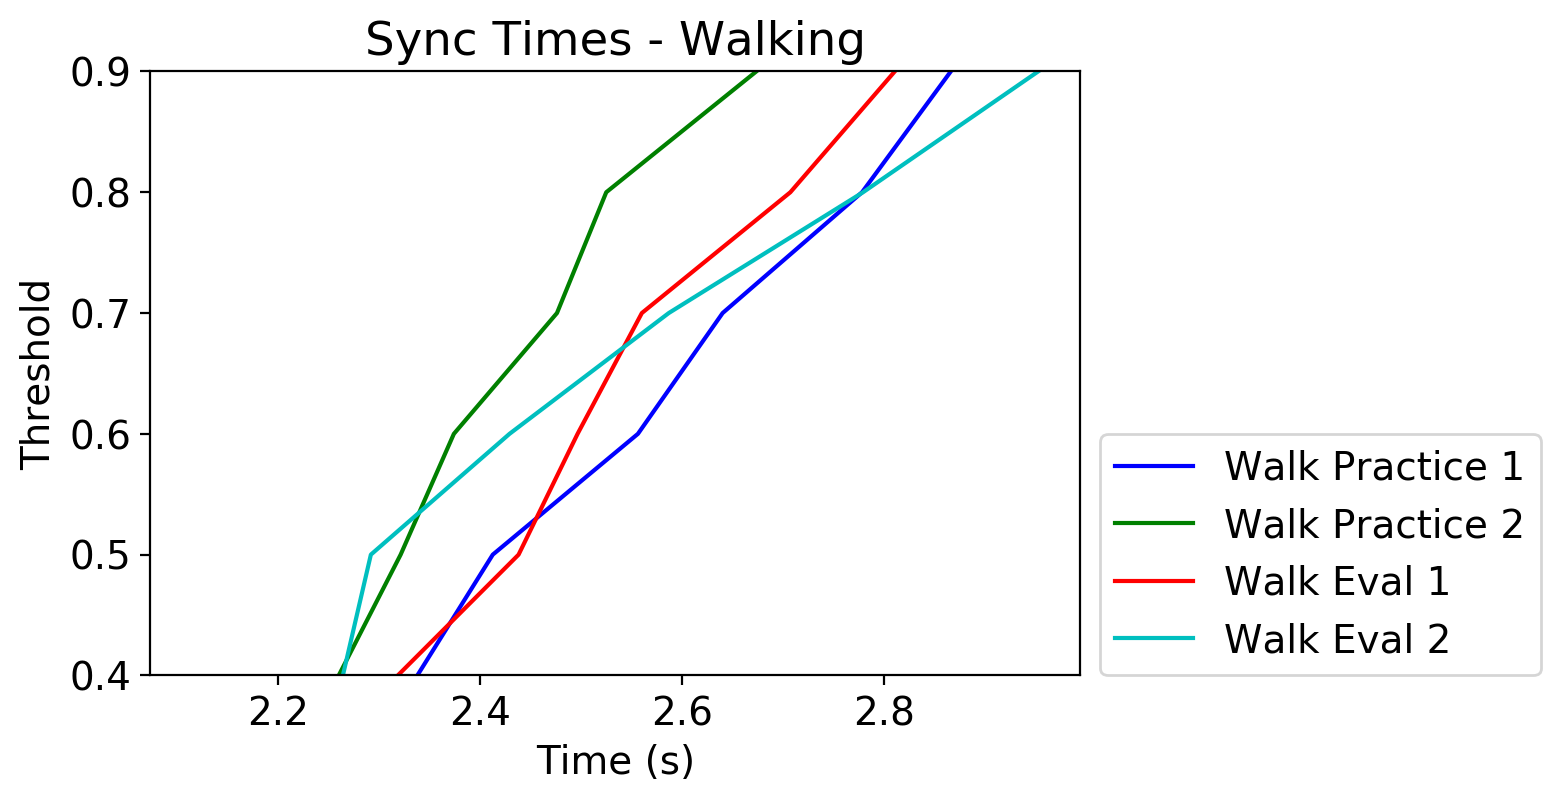

In [29]:
# this block iterates through all of the study data files to generate the sync times graph

from functools import reduce

# baseFilePath = "/Users/jwpilly/Documents/Research/Synchro/Study_v2/"
# baseFilePath = "/Users/jwpilly/Research/Synchro/Study_v2/"
# baseFilePath = "/Volumes/HanSolo/Dropbox/Georgia Tech/Synchro/Data/Study_v1/Flat/sync1000/"
baseFilePath = "/media/jwpilly/PillowDisk/Research/Synchro/figuredata/figure13/Study_v2/"
presults = []
for root, folders, files in os.walk(baseFilePath):
    if not root.endswith("synchro") or "MACOSX" in root:
        continue
    sfolders = sorted(folders, key=lambda x : int(x.split("_")[0].replace("t", "")))
    efolders = [f for f in sfolders[:] if "prep" not in f]
    efolderpaths = [root + "/" + f + "/" for f in efolders]
#     print(efolderpaths)
    efoldertimes = [(efolderpaths[i].split("_")[-1][:-1] + str(i), processSyncFile(efolderpaths[i])) for i in range(len(efolderpaths))]
    presults.append(efoldertimes)
# thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.8, 0.85, 0.9, 0.95]
thresholds = [i / 10 for i in range(10)]
# print(efoldertimes)
syncresults = []
for th in thresholds:
    presultsa = [[i[1][th] for i in t] for t in [sorted(r) for r in presults]]
    paverages = reduce(lambda x, y : np.array(x) + np.array(y), presultsa) / len(presultsa)
    syncresults.append(paverages)

# this block plots the results of the sync times graph. depending on which block was run before this one, the graph outputted is for sync data/noise data

plt.clf()
x = thresholds
plt.title("Sync Times - Sitting")
plt.xlabel("Time (s)")
plt.ylabel("Threshold")
plt.ylim(0.4, 0.9)
plt.plot([syncresults[i][0] for i in range(len(x))],x, label="Sit Practice 1", color='b')
plt.plot([syncresults[i][1] for i in range(len(x))],x, label="Sit Practice 2", color='g')
plt.plot([syncresults[i][2] for i in range(len(x))],x, label="Sit Eval 1", color='r')
plt.plot([syncresults[i][3] for i in range(len(x))],x, label="Sit Eval 2", color='c')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.2))
plt.show()
plt.clf()
plt.title("Sync Times - Walking")
plt.xlabel("Time (s)")
plt.ylabel("Threshold")
plt.ylim(0.4, 0.9)
plt.plot([syncresults[i][4] for i in range(len(x))], x, label="Walk Practice 1", color='b')
plt.plot([syncresults[i][5] for i in range(len(x))], x, label="Walk Practice 2", color='g')
plt.plot([syncresults[i][6] for i in range(len(x))], x, label="Walk Eval 1", color='r')
plt.plot([syncresults[i][7] for i in range(len(x))], x, label="Walk Eval 2", color='c')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.2))
plt.show()

## Figure 15

In [ ]:
from functools import reduce
import os.path


from functools import reduce

# baseFilePath = "/Users/jwpilly/Documents/Research/Synchro/Study_v2/"
# baseFilePath = "/Users/jwpilly/Research/Synchro/Study_v2/"
# baseFilePath = "/Volumes/HanSolo/Dropbox/Georgia Tech/Synchro/Data/Study_v1/Flat/sync1000/"
baseFilePath = "/media/jwpilly/PillowDisk/Research/Synchro/figuredata/figure13/Study_v2/"
presults = []
for root, folders, files in os.walk(baseFilePath):
    if not root.endswith("synchro") or "MACOSX" in root:
        continue
    sfolders = sorted(folders, key=lambda x : int(x.split("_")[0].replace("t", "")))
    efolders = [f for f in sfolders[:] if "prep" not in f]
    efolderpaths = [root + "/" + f + "/" for f in efolders]
#     print(efolderpaths)
    efoldertimes = [(efolderpaths[i].split("_")[-1][:-1] + str(i), processSyncFile(efolderpaths[i])) for i in range(len(efolderpaths))]
    presults.append(efoldertimes)
# thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.8, 0.85, 0.9, 0.95]
thresholds = [i / 10 for i in range(10)]
# print(efoldertimes)
syncresults = []
for th in thresholds:
    presultsa = [[i[1][th] for i in t] for t in [sorted(r) for r in presults]]
    paverages = reduce(lambda x, y : np.array(x) + np.array(y), presultsa) / len(presultsa)
    syncresults.append(paverages)

baseFilePath = "/media/jwpilly/PillowDisk/Research/Synchro/figuredata/figure13/Study_v2/"
presults = []
for root, folders, files in os.walk(baseFilePath):
    if not root.endswith("swipe"):
        continue
    sfolders = sorted(folders, key=lambda x : int(x.split("_")[0].replace("t", "")))
    efolders = [f for f in sfolders[:] if "prep" not in f]
    efolderpaths = [root + "/" + f + "/" for f in efolders]
    efoldertimes = [(efolderpaths[i].split("_")[-1][:-1] + str(i), processSwipeFile(efolderpaths[i])) for i in range(len(efolderpaths))]
    presults.append(efoldertimes)
presultsa = [[i[1] for i in t] for t in [sorted(r) for r in presults]]
paverages = reduce(lambda x, y : np.array(x) + np.array(y), presultsa) / len(presultsa)
print(paverages)
swipe_sit = np.mean([paverages[i] for i in range(4)])
swipe_walk = np.mean([paverages[i + 4] for i in range(4)])
swipe_times = paverages
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.clf()
labels = ["Swipe", "0.6", "0.7", "0.8", "0.9"]
width= 0.3
ind = np.arange(len(labels))
plt.bar(ind, [np.mean(swipe_times[:4]), np.mean(syncresults[2][:4]), np.mean(syncresults[4][:4]), np.mean(syncresults[6][:4]), np.mean(syncresults[8][:4])], width=width, label="Sit", color="purple")
plt.bar(ind + width * 1.2, [np.mean(swipe_times[4:]), np.mean(syncresults[2][4:]), np.mean(syncresults[4][4:]), np.mean(syncresults[6][4:]), np.mean(syncresults[8][4:])], width=width, label="Walk", color="orange")
plt.xticks( 0.1 + ind + width / 1.5, labels)
plt.xlabel("Threshold")
plt.ylabel("Sync Time (s)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.2))
# plt.savefig("overall_performance_bar.png", bbox_inches='tight')
plt.show()

## Figure 13

In [36]:
import os.path
import pickle

def figure13(activity):
    CF = "figure13_" + activity + ".pickle"
    # this block is used to specify which activity to use when generating the 3d plots
    ACTIVITY = activity
    # this block is used to calculate the true positives and false positives of the 3d plots the data is stored in tps and fps

    # tp = syncRateFile("/Users/jwpilly/Research/Synchro/Study_v2/P1/synchro/t20170401112834_p1_sit/")
    # fp = syncRateFile("/Users/jwpilly/Research/Synchro/Study_v2/P1/synchro/t20170401112834_p1_sit/", False)
    # baseFilePath = "/Users/jwpilly/Research/Synchro/Study_v2/"
    # baseFilePath = "/Users/jwpilly/Research/Synchro/Study_v1_750/"
    baseFilePath = "/media/jwpilly/PillowDisk/Research/Synchro/figuredata/figure13/Study_v2/"
    if os.path.isfile(CF):
        stats = pickle.load(open(CF, "rb"))
        tps = stats['tps']
        fps = stats['fps']
        ttot = stats['ttot']
        ftot = stats['ftot']
    else:
        tps = {}
        fps = {}
        ttot = {}
        ftot = {}

        for root, folders, files in os.walk(baseFilePath):
            if not root.endswith("synchro") or "MACOSX" in root:
                continue
            sfolders = sorted(folders, key=lambda x : int(x.split("_")[0].replace("t", "")))
            efolders = [f for f in sfolders[:] if "prep" not in f in f]
            if ACTIVITY != "all":
                efolderpaths = [root + "/" + f + "/" for f in efolders if ACTIVITY in f]
            else:
                efolderpaths = [root + "/" + f + "/" for f in efolders]
            etps = [syncRateFile(efolderpaths[i]) for i in range(len(efolderpaths))]
            efps = [syncRateFile(efolderpaths[i], True) for i in range(len(efolderpaths))]
            for th in thresholds:
                if th not in tps:
                    tps[th] = np.array([0 for i in times])
                if th not in fps:
                    fps[th] = np.array([0 for i in times])
                if th not in ttot:
                    ttot[th] = np.array([0 for i in times])
                if th not in ftot:
                    ftot[th] = np.array([0 for i in times])
                for stps in etps:
                    tps[th] += np.array(stps[th][0])
                    ttot[th] += np.array(stps[th][1])
                for sfps in efps:
                    fps[th] += np.array(sfps[th][0])
                    ftot[th] += np.array(sfps[th][1])
        stats = {}
        stats['tps'] = tps
        stats['fps'] = fps
        stats['ttot'] = ttot
        stats['ftot'] = ftot
        pickle.dump(stats, open(CF, "wb"))

    # this block is used to generate the precision graph with 0.5 * tp + 0.5 tn

    precisions = []
    for th in thresholds:
        for ti in range(len(times)):
            ptime = times[ti]
            if ptime < IGNORE_TIME / 1000:
                continue
            tp_rate = tps[th][ti] / ttot[th][ti]
            fp_rate = fps[th][ti] / ftot[th][ti]
            prec = 0.5 * tp_rate + 0.5 * (1 - fp_rate)
    #         prec = tp_rate
            point = [th, ptime, prec]
            precisions.append(point)
    precisions = np.array(precisions)
    xd = precisions[:,0]
    yd = precisions[:,1]
    zd = precisions[:,2]

    import matplotlib.mlab as mlab
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.collections import PolyCollection
    from matplotlib.colors import colorConverter
    from matplotlib import cm


    plt.clf()
    fig = plt.figure(figsize=(8, 6))
    # ax = fig.gca(projection='3d')
    ax = fig.gca()
    xi = np.linspace(np.min(xd), np.max(xd))
    yi = np.linspace(np.min(yd), np.max(yd))
    X, Y = np.meshgrid(xi, yi)
    Z = mlab.griddata(xd, yd, zd, xi, yi, interp='linear')
    # Z = precisions
    # surf = ax.plot_surface(X, Y, Z, cmap=cm.jet)
    # ax.set_zlim3d(np.min(Z), np.max(Z))
    # fig.colorbar(surf)
    # contour = ax.contour(xd, yd, zd, cmap=cm.jet)
    contour = ax.contourf(X, Y, Z, np.linspace(0.0, 1.0, 21, endpoint=True), cmap=cm.jet)
    fig.colorbar(contour)


    ax.set_xlabel("Threshold")
    ax.set_ylabel("Time (s)")
    plt.show()

figure13("all")
figure13("sit")
figure13("walk")

IndexError: index 51 is out of bounds for axis 0 with size 51